<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Splitting-to-test-and-train" data-toc-modified-id="Splitting-to-test-and-train-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Splitting to test and train</a></span></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Training-file" data-toc-modified-id="Training-file-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Training file</a></span></li><li><span><a href="#Test-file-WOE" data-toc-modified-id="Test-file-WOE-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Test file WOE</a></span></li></ul></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preprocessing</a></span></li><li><span><a href="#Loading-WOE-Files" data-toc-modified-id="Loading-WOE-Files-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Loading WOE Files</a></span></li><li><span><a href="#TFIDF" data-toc-modified-id="TFIDF-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TFIDF</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Light-GBM" data-toc-modified-id="Light-GBM-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Light GBM</a></span></li></ul></li><li><span><a href="#Count-Vectorizer" data-toc-modified-id="Count-Vectorizer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Count Vectorizer</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Light-GBM" data-toc-modified-id="Light-GBM-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Light GBM</a></span></li></ul></li><li><span><a href="#Loading-embeddings-&amp;-processing-text-to-suit-embeddings" data-toc-modified-id="Loading-embeddings-&amp;-processing-text-to-suit-embeddings-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Loading embeddings &amp; processing text to suit embeddings</a></span></li><li><span><a href="#Loading-processed-file" data-toc-modified-id="Loading-processed-file-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Loading processed file</a></span></li><li><span><a href="#BiLSTM" data-toc-modified-id="BiLSTM-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>BiLSTM</a></span></li><li><span><a href="#Combined-Model" data-toc-modified-id="Combined-Model-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Combined Model</a></span><ul class="toc-item"><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>Logistic Regression</a></span></li><li><span><a href="#Logistic-regression-with-non-deep-learning-models" data-toc-modified-id="Logistic-regression-with-non-deep-learning-models-10.2"><span class="toc-item-num">10.2&nbsp;&nbsp;</span>Logistic regression with non deep learning models</a></span></li><li><span><a href="#Light-GBM" data-toc-modified-id="Light-GBM-10.3"><span class="toc-item-num">10.3&nbsp;&nbsp;</span>Light GBM</a></span></li><li><span><a href="#Concatenating-woe-scores-to-training-file" data-toc-modified-id="Concatenating-woe-scores-to-training-file-10.4"><span class="toc-item-num">10.4&nbsp;&nbsp;</span>Concatenating woe scores to training file</a></span></li></ul></li></ul></div>

In [1]:
# Importing packages
import os
import csv
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import scipy as sp
import lightgbm as lgb

In [2]:
# Function to select threshold value to get optimum f1 score 
def threshold_search(y_true,y_proba):
    best_threshold=0
    best_score=0
    for threshold in [i*0.01 for i in range(100)]:
        score=metrics.f1_score(y_true=y_true, y_pred=y_proba>threshold)
        if score>best_score:
            best_threshold=threshold
            best_score=score
    search_result={'threshold':best_threshold,'f1':best_score}
    return search_result

In [3]:
# Function for generating WOE values for given dataframe and column
def woe(df,targ,col):
    if((df[col].dtype!=object) and (df[col].nunique()>10)):
        df1=df[[col,targ]].sort_values(col)
        totalgood=sum(df[targ]==0)
        totalbad=sum(df[targ]==1)
        df1['bin']=pd.qcut(df1[col],20,duplicates='drop',precision=20,)
        df2=df1.drop(col,axis=1)
        ct=pd.crosstab(df2['bin'],df2[targ],colnames=[None])
        ct.reset_index(0,inplace=True)
        for i in range(len(ct)):
            if ct[1][i]==0:
                ct[1][i]=1
        for i in range(len(ct)):
            if ct[0][i]==0:
                ct[0][i]=1
        ct['% Good']=ct[0]/totalgood
        ct['% Bad']=ct[1]/totalbad
        ct['WOE']=np.log(ct['% Good']/ct['% Bad'])
        ct['IV']=(ct['% Good']-ct['% Bad'])*ct['WOE']
        if sum(df[col].isna())>1:
            missing=df.loc[df[col].isna(),]
            ones=sum(missing['TARGET']==1)
            zeroes=sum(missing['TARGET']==0)
            good=(zeroes/totalgood)
            if ones==0:
                bad=(ones+1/totalbad)
            else:
                bad=(ones/totalbad)
            woev=np.log(good/bad)
            iv=(good-bad)*woev
            ct.loc[max(ct.index)+1]=['Missing Values',zeroes,ones,good,bad,woev,iv]
        return(ct)
    else:
        ct=pd.crosstab(df[col],df[targ],colnames=[None])
        totalgood=sum(df[targ]==0)
        totalbad=sum(df[targ]==1)
        ct.reset_index(0,inplace=True)
        for i in range(len(ct)):
            if ct[1][i]==0:
                ct[1][i]=1
        for i in range(len(ct)):
            if ct[0][i]==0:
                ct[0][i]=1
        ct['% Good']=ct[0]/totalgood
        ct['% Bad']=ct[1]/totalbad
        ct['WOE']=np.log(ct['% Good']/ct['% Bad'])
        ct['IV']=(ct['% Good']-ct['% Bad'])*ct['WOE']
        if sum(df[col].isna())>1:
            missing=df.loc[df[col].isna(),]
            ones=sum(missing['TARGET']==1)
            zeroes=sum(missing['TARGET']==0)
            if ones==0:
                bad=(ones+1/totalbad)
            else:
                bad=(ones/totalbad)
            good=zeroes/totalgood
            woev=np.log(good/bad)
            iv=(good-bad)*woev
            ct.loc[max(ct.index)+1]=['Missing Values',zeroes,ones,good,bad,woev,iv]
        return(ct)

In [7]:
pd.set_option('max_colwidth', 400)

In [4]:
# Main train file
insin=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\train.csv')
insin.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [6]:
print(insin.shape)

(1306122, 3)


<BarContainer object of 2 artists>

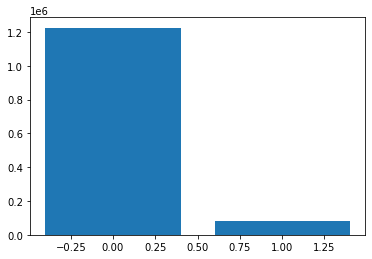

In [7]:
# Class distribution
plt.bar(x=[0,1],height=insin['target'].value_counts())

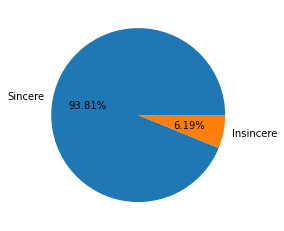

In [8]:
# Class distribution
plt.pie(insin['target'].value_counts(),labels=['Sincere','Insincere'],autopct='%1.2f%%')
plt.show()

In [9]:
# Missing value check
insin.isna().sum()

qid              0
question_text    0
target           0
dtype: int64

In [10]:
# Check for duplication
insin.duplicated(subset=["question_text","qid","target"]).value_counts()

False    1306122
dtype: int64

#### Splitting to test and train

In [9]:
# Splitting to train and test
train=insin.sample(frac=0.8,random_state=49) #random state is a seed value
test=insin.drop(train.index)

In [10]:
test.drop('qid',inplace=True,axis=1)
train.drop('qid',inplace=True,axis=1)

#### Feature Engineering

##### Training file

In [8]:
# Sentence length
leng=[len(train.loc[i,'question_text']) for i in train.index]
train['Length']=leng

In [14]:
# Getting number of words in sentence
words=[len(train.loc[i,'question_text'].split()) for i in train.index]
train['Words']=words
train

,question_text,target,Length,Words
172360,Is there any beach available in Delhi for night out?,0,52,10
188522,What is the unit of vector parallel to each of vector?,0,54,11
1235537,How change LTE to VOlTE?,0,24,5
345543,What percentage of US Democrat politicians are lawyers?,0,55,8
566414,How did Cabela's Inc. manages to establish such large stores?,0,61,10
...,...,...,...,...
1180555,Where can I buy tamper proof courier bags online?,0,49,9
155574,What are some reasons to trust a Jew?,1,37,8
1130815,What are the considerations in using a static class vs. a singleton? I need a class to handle functions with no relevance to specific instances.,0,144,25
107187,What is the purpose of the bit in a horse harness?,0,50,11


In [15]:
# Getting number of special characters in sentence
spchar = [len(re.sub('[A-Za-z0-9\s]+', '', train.loc[i,'question_text'])) for i in train.index] 
train['Special Characters']=spchar

In [16]:
# Getting number of capital words used in sentence
capwrd=[len(re.findall('([A-Z][a-z]+)', train.loc[i,'question_text'])) for i in train.index]
train['Capital Words']=capwrd

In [17]:
# Getting number of positive words used in sentence
senti=SentimentIntensityAnalyzer()
poslen=[]
for i in train.index:
    j=train.loc[i,'question_text']
    pos=[]
    for p in j.split():
        if (senti.polarity_scores(p)['compound']) >= 0.5:
            pos.append(p)
    poslen.append(len(pos))
train['Positive words']=poslen
train

,question_text,target,Length,Words,Special Characters,Capital Words,Positive words
172360,Is there any beach available in Delhi for night out?,0,52,10,1,2,0
188522,What is the unit of vector parallel to each of vector?,0,54,11,1,1,0
1235537,How change LTE to VOlTE?,0,24,5,1,2,0
345543,What percentage of US Democrat politicians are lawyers?,0,55,8,1,2,0
566414,How did Cabela's Inc. manages to establish such large stores?,0,61,10,3,3,0
...,...,...,...,...,...,...,...
1180555,Where can I buy tamper proof courier bags online?,0,49,9,1,1,0
155574,What are some reasons to trust a Jew?,1,37,8,1,2,1
1130815,What are the considerations in using a static class vs. a singleton? I need a class to handle functions with no relevance to specific instances.,0,144,25,3,1,0
107187,What is the purpose of the bit in a horse harness?,0,50,11,1,1,0


In [18]:
# Number of negative words used in sentence
neglen=[]
for i in train.index:
    j=train.loc[i,'question_text']
    neg=[]
    for p in j.split():
        if (senti.polarity_scores(p)['compound']) <= -0.5:
            neg.append(p)
    neglen.append(len(neg))
train['Negative words']=neglen
train

,question_text,target,Length,Words,Special Characters,Capital Words,Positive words,Negative words
172360,Is there any beach available in Delhi for night out?,0,52,10,1,2,0,0
188522,What is the unit of vector parallel to each of vector?,0,54,11,1,1,0,0
1235537,How change LTE to VOlTE?,0,24,5,1,2,0,0
345543,What percentage of US Democrat politicians are lawyers?,0,55,8,1,2,0,0
566414,How did Cabela's Inc. manages to establish such large stores?,0,61,10,3,3,0,0
...,...,...,...,...,...,...,...,...
1180555,Where can I buy tamper proof courier bags online?,0,49,9,1,1,0,0
155574,What are some reasons to trust a Jew?,1,37,8,1,2,1,0
1130815,What are the considerations in using a static class vs. a singleton? I need a class to handle functions with no relevance to specific instances.,0,144,25,3,1,0,0
107187,What is the purpose of the bit in a horse harness?,0,50,11,1,1,0,0


In [19]:
# Number of stop words used in sentence
stp=nltk.corpus.stopwords.words('english')
nostp=[]
for i in train.index:
    j=train.loc[i,'question_text']
    stpwrds=[]
    for p in j.split():
        if p in stp:
            stpwrds.append(p)
    nostp.append(len(stpwrds))
train['Stop words']=nostp
train

,question_text,target,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words
172360,Is there any beach available in Delhi for night out?,0,52,10,1,2,0,0,4
188522,What is the unit of vector parallel to each of vector?,0,54,11,1,1,0,0,6
1235537,How change LTE to VOlTE?,0,24,5,1,2,0,0,1
345543,What percentage of US Democrat politicians are lawyers?,0,55,8,1,2,0,0,2
566414,How did Cabela's Inc. manages to establish such large stores?,0,61,10,3,3,0,0,3
...,...,...,...,...,...,...,...,...,...
1180555,Where can I buy tamper proof courier bags online?,0,49,9,1,1,0,0,1
155574,What are some reasons to trust a Jew?,1,37,8,1,2,1,0,4
1130815,What are the considerations in using a static class vs. a singleton? I need a class to handle functions with no relevance to specific instances.,0,144,25,3,1,0,0,10
107187,What is the purpose of the bit in a horse harness?,0,50,11,1,1,0,0,6


In [20]:
# Number of exclamation marks used in sentence
exc=[]
for i in train.index:
    c=0
    j=train.loc[i,'question_text']
    for k in j.split():
        if k.endswith('!'):
            c+=1
    exc.append(c)
train['Exclamation']=exc

In [21]:
# Number of question marks used in sentence
ques=[]
for i in train.index:
    c=0
    j=train.loc[i,'question_text']
    for k in j.split():
        if k.endswith('?'):
            c+=1
    ques.append(c)
train["Question"]=ques

In [22]:
# Finding the different parts of speech used in sentence
deter=[]
noun=[]
verb=[]
adj=[]
prn=[]
advr=[]
whq=[]
for i in train.index:
    j=train.loc[i,'question_text']
    k=nltk.pos_tag(j.split())
    det=[x[1] for x in k if x[1].startswith('DT')]
    nn=[x[1] for x in k if x[1].startswith('NN')]
    vb=[x[1] for x in k if x[1].startswith('VB')]
    ad=[x[1] for x in k if x[1].startswith('JJ')]
    pr=[x[1] for x in k if x[1].startswith('PR')]
    adv=[x[1] for x in k if x[1].startswith('RB')]
    wh=[x[1] for x in k if x[1].startswith('WR')]
    deter.append(len(det))
    noun.append(len(nn))
    verb.append(len(vb))
    adj.append(len(ad))
    prn.append(len(pr))
    advr.append(len(adv))
    whq.append(len(wh))
    if len(deter)%100==0:
        print(len(deter),end=' ')

100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 9200 9300 9400 9500 9600 9700 9800 9900 10000 10100 10200 10300 10400 10500 10600 10700 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900 18000 18100 18200 18300 18400 1850

133200 133300 133400 133500 133600 133700 133800 133900 134000 134100 134200 134300 134400 134500 134600 134700 134800 134900 135000 135100 135200 135300 135400 135500 135600 135700 135800 135900 136000 136100 136200 136300 136400 136500 136600 136700 136800 136900 137000 137100 137200 137300 137400 137500 137600 137700 137800 137900 138000 138100 138200 138300 138400 138500 138600 138700 138800 138900 139000 139100 139200 139300 139400 139500 139600 139700 139800 139900 140000 140100 140200 140300 140400 140500 140600 140700 140800 140900 141000 141100 141200 141300 141400 141500 141600 141700 141800 141900 142000 142100 142200 142300 142400 142500 142600 142700 142800 142900 143000 143100 143200 143300 143400 143500 143600 143700 143800 143900 144000 144100 144200 144300 144400 144500 144600 144700 144800 144900 145000 145100 145200 145300 145400 145500 145600 145700 145800 145900 146000 146100 146200 146300 146400 146500 146600 146700 146800 146900 147000 147100 147200 147300 147400

250400 250500 250600 250700 250800 250900 251000 251100 251200 251300 251400 251500 251600 251700 251800 251900 252000 252100 252200 252300 252400 252500 252600 252700 252800 252900 253000 253100 253200 253300 253400 253500 253600 253700 253800 253900 254000 254100 254200 254300 254400 254500 254600 254700 254800 254900 255000 255100 255200 255300 255400 255500 255600 255700 255800 255900 256000 256100 256200 256300 256400 256500 256600 256700 256800 256900 257000 257100 257200 257300 257400 257500 257600 257700 257800 257900 258000 258100 258200 258300 258400 258500 258600 258700 258800 258900 259000 259100 259200 259300 259400 259500 259600 259700 259800 259900 260000 260100 260200 260300 260400 260500 260600 260700 260800 260900 261000 261100 261200 261300 261400 261500 261600 261700 261800 261900 262000 262100 262200 262300 262400 262500 262600 262700 262800 262900 263000 263100 263200 263300 263400 263500 263600 263700 263800 263900 264000 264100 264200 264300 264400 264500 264600

367600 367700 367800 367900 368000 368100 368200 368300 368400 368500 368600 368700 368800 368900 369000 369100 369200 369300 369400 369500 369600 369700 369800 369900 370000 370100 370200 370300 370400 370500 370600 370700 370800 370900 371000 371100 371200 371300 371400 371500 371600 371700 371800 371900 372000 372100 372200 372300 372400 372500 372600 372700 372800 372900 373000 373100 373200 373300 373400 373500 373600 373700 373800 373900 374000 374100 374200 374300 374400 374500 374600 374700 374800 374900 375000 375100 375200 375300 375400 375500 375600 375700 375800 375900 376000 376100 376200 376300 376400 376500 376600 376700 376800 376900 377000 377100 377200 377300 377400 377500 377600 377700 377800 377900 378000 378100 378200 378300 378400 378500 378600 378700 378800 378900 379000 379100 379200 379300 379400 379500 379600 379700 379800 379900 380000 380100 380200 380300 380400 380500 380600 380700 380800 380900 381000 381100 381200 381300 381400 381500 381600 381700 381800

484800 484900 485000 485100 485200 485300 485400 485500 485600 485700 485800 485900 486000 486100 486200 486300 486400 486500 486600 486700 486800 486900 487000 487100 487200 487300 487400 487500 487600 487700 487800 487900 488000 488100 488200 488300 488400 488500 488600 488700 488800 488900 489000 489100 489200 489300 489400 489500 489600 489700 489800 489900 490000 490100 490200 490300 490400 490500 490600 490700 490800 490900 491000 491100 491200 491300 491400 491500 491600 491700 491800 491900 492000 492100 492200 492300 492400 492500 492600 492700 492800 492900 493000 493100 493200 493300 493400 493500 493600 493700 493800 493900 494000 494100 494200 494300 494400 494500 494600 494700 494800 494900 495000 495100 495200 495300 495400 495500 495600 495700 495800 495900 496000 496100 496200 496300 496400 496500 496600 496700 496800 496900 497000 497100 497200 497300 497400 497500 497600 497700 497800 497900 498000 498100 498200 498300 498400 498500 498600 498700 498800 498900 499000

602100 602200 602300 602400 602500 602600 602700 602800 602900 603000 603100 603200 603300 603400 603500 603600 603700 603800 603900 604000 604100 604200 604300 604400 604500 604600 604700 604800 604900 605000 605100 605200 605300 605400 605500 605600 605700 605800 605900 606000 606100 606200 606300 606400 606500 606600 606700 606800 606900 607000 607100 607200 607300 607400 607500 607600 607700 607800 607900 608000 608100 608200 608300 608400 608500 608600 608700 608800 608900 609000 609100 609200 609300 609400 609500 609600 609700 609800 609900 610000 610100 610200 610300 610400 610500 610600 610700 610800 610900 611000 611100 611200 611300 611400 611500 611600 611700 611800 611900 612000 612100 612200 612300 612400 612500 612600 612700 612800 612900 613000 613100 613200 613300 613400 613500 613600 613700 613800 613900 614000 614100 614200 614300 614400 614500 614600 614700 614800 614900 615000 615100 615200 615300 615400 615500 615600 615700 615800 615900 616000 616100 616200 616300

719200 719300 719400 719500 719600 719700 719800 719900 720000 720100 720200 720300 720400 720500 720600 720700 720800 720900 721000 721100 721200 721300 721400 721500 721600 721700 721800 721900 722000 722100 722200 722300 722400 722500 722600 722700 722800 722900 723000 723100 723200 723300 723400 723500 723600 723700 723800 723900 724000 724100 724200 724300 724400 724500 724600 724700 724800 724900 725000 725100 725200 725300 725400 725500 725600 725700 725800 725900 726000 726100 726200 726300 726400 726500 726600 726700 726800 726900 727000 727100 727200 727300 727400 727500 727600 727700 727800 727900 728000 728100 728200 728300 728400 728500 728600 728700 728800 728900 729000 729100 729200 729300 729400 729500 729600 729700 729800 729900 730000 730100 730200 730300 730400 730500 730600 730700 730800 730900 731000 731100 731200 731300 731400 731500 731600 731700 731800 731900 732000 732100 732200 732300 732400 732500 732600 732700 732800 732900 733000 733100 733200 733300 733400

836500 836600 836700 836800 836900 837000 837100 837200 837300 837400 837500 837600 837700 837800 837900 838000 838100 838200 838300 838400 838500 838600 838700 838800 838900 839000 839100 839200 839300 839400 839500 839600 839700 839800 839900 840000 840100 840200 840300 840400 840500 840600 840700 840800 840900 841000 841100 841200 841300 841400 841500 841600 841700 841800 841900 842000 842100 842200 842300 842400 842500 842600 842700 842800 842900 843000 843100 843200 843300 843400 843500 843600 843700 843800 843900 844000 844100 844200 844300 844400 844500 844600 844700 844800 844900 845000 845100 845200 845300 845400 845500 845600 845700 845800 845900 846000 846100 846200 846300 846400 846500 846600 846700 846800 846900 847000 847100 847200 847300 847400 847500 847600 847700 847800 847900 848000 848100 848200 848300 848400 848500 848600 848700 848800 848900 849000 849100 849200 849300 849400 849500 849600 849700 849800 849900 850000 850100 850200 850300 850400 850500 850600 850700

953800 953900 954000 954100 954200 954300 954400 954500 954600 954700 954800 954900 955000 955100 955200 955300 955400 955500 955600 955700 955800 955900 956000 956100 956200 956300 956400 956500 956600 956700 956800 956900 957000 957100 957200 957300 957400 957500 957600 957700 957800 957900 958000 958100 958200 958300 958400 958500 958600 958700 958800 958900 959000 959100 959200 959300 959400 959500 959600 959700 959800 959900 960000 960100 960200 960300 960400 960500 960600 960700 960800 960900 961000 961100 961200 961300 961400 961500 961600 961700 961800 961900 962000 962100 962200 962300 962400 962500 962600 962700 962800 962900 963000 963100 963200 963300 963400 963500 963600 963700 963800 963900 964000 964100 964200 964300 964400 964500 964600 964700 964800 964900 965000 965100 965200 965300 965400 965500 965600 965700 965800 965900 966000 966100 966200 966300 966400 966500 966600 966700 966800 966900 967000 967100 967200 967300 967400 967500 967600 967700 967800 967900 968000

In [23]:
# Setting the numbers as columns in training file
train['Articles']=deter
train['Nouns']=noun
train['Verbs']=verb
train['Adjectives']=adj
train['Pronouns']=prn
train['Question Words']=whq
train['Adverbs']=advr

In [24]:
# Getting positive, negative, neutral and overall sentiment score
neg=[]
neu=[]
pos=[]
comp=[]
for i in train.index:
    j=train.loc[i,'question_text']
    k=senti.polarity_scores(j)
    neg.append(k['neg'])
    neu.append(k['neu'])
    pos.append(k['pos'])
    comp.append(k['compound'])
    if len(neg)%10000==0:
        print(len(neg),end=' ')

10000 20000 30000 40000 50000 60000 70000 80000 90000 100000 110000 120000 130000 140000 150000 160000 170000 180000 190000 200000 210000 220000 230000 240000 250000 260000 270000 280000 290000 300000 310000 320000 330000 340000 350000 360000 370000 380000 390000 400000 410000 420000 430000 440000 450000 460000 470000 480000 490000 500000 510000 520000 530000 540000 550000 560000 570000 580000 590000 600000 610000 620000 630000 640000 650000 660000 670000 680000 690000 700000 710000 720000 730000 740000 750000 760000 770000 780000 790000 800000 810000 820000 830000 840000 850000 860000 870000 880000 890000 900000 910000 920000 930000 940000 950000 960000 970000 980000 990000 1000000 1010000 1020000 1030000 1040000 

In [25]:
#Setting the values in training file
train['Positive score']=pos
train['Negative score']=neg
train['Neutral score']=neu
train['Final score']=comp
train

,question_text,target,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words,Exclamation,...,Nouns,Verbs,Adjectives,Pronouns,Question Words,Adverbs,Positive score,Negative score,Neutral score,Final score
172360,Is there any beach available in Delhi for night out?,0,52,10,1,2,0,0,4,0,...,4,1,1,0,0,0,0.000,0.000,1.000,0.0000
188522,What is the unit of vector parallel to each of vector?,0,54,11,1,1,0,0,6,0,...,4,1,0,0,0,0,0.000,0.000,1.000,0.0000
1235537,How change LTE to VOlTE?,0,24,5,1,2,0,0,1,0,...,2,1,0,0,1,0,0.000,0.000,1.000,0.0000
345543,What percentage of US Democrat politicians are lawyers?,0,55,8,1,2,0,0,2,0,...,4,1,1,0,0,0,0.000,0.000,1.000,0.0000
566414,How did Cabela's Inc. manages to establish such large stores?,0,61,10,3,3,0,0,3,0,...,3,3,2,0,1,0,0.000,0.000,1.000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1180555,Where can I buy tamper proof courier bags online?,0,49,9,1,1,0,0,1,0,...,3,2,0,1,1,0,0.000,0.000,1.000,0.0000
155574,What are some reasons to trust a Jew?,1,37,8,1,2,1,0,4,0,...,2,2,0,0,0,0,0.355,0.000,0.645,0.5106
1130815,What are the considerations in using a static class vs. a singleton? I need a class to handle functions with no relevance to specific instances.,0,144,25,3,1,0,0,10,0,...,7,4,2,1,0,0,0.000,0.099,0.901,-0.2960
107187,What is the purpose of the bit in a horse harness?,0,50,11,1,1,0,0,6,0,...,4,1,0,0,0,0,0.000,0.000,1.000,0.0000


In [26]:
# Saving file
train.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\feature.csv')

In [9]:
#Reading the file
feature=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\feature.csv')

In [10]:
feature.head()

,Unnamed: 0,question_text,target,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words,...,Nouns,Verbs,Adjectives,Pronouns,Question Words,Adverbs,Positive score,Negative score,Neutral score,Final score
0,172360,Is there any beach available in Delhi for night out?,0,52,10,1,2,0,0,4,...,4,1,1,0,0,0,0.0,0.0,1.0,0.0
1,188522,What is the unit of vector parallel to each of vector?,0,54,11,1,1,0,0,6,...,4,1,0,0,0,0,0.0,0.0,1.0,0.0
2,1235537,How change LTE to VOlTE?,0,24,5,1,2,0,0,1,...,2,1,0,0,1,0,0.0,0.0,1.0,0.0
3,345543,What percentage of US Democrat politicians are lawyers?,0,55,8,1,2,0,0,2,...,4,1,1,0,0,0,0.0,0.0,1.0,0.0
4,566414,How did Cabela's Inc. manages to establish such large stores?,0,61,10,3,3,0,0,3,...,3,3,2,0,1,0,0.0,0.0,1.0,0.0


In [11]:
# Getting information value metric for feature selection
iv={}
for i in feature.drop(['target','question_text','Unnamed: 0'],axis=1).columns:
    ct=woe(feature,'target',i)
    iv[i]=sum(ct['IV'])
impcols=[]
for i,j in iv.items():
    if j>=0.05:
        impcols.append(i)
impcols

['Length',
 'Words',
 'Special Characters',
 'Capital Words',
 'Negative words',
 'Stop words',
 'Question',
 'Articles',
 'Nouns',
 'Verbs',
 'Adjectives',
 'Question Words',
 'Adverbs',
 'Positive score',
 'Negative score',
 'Neutral score',
 'Final score']

In [12]:
# Choosing imporant columns
traincols=feature.loc[:,impcols]
traincols['target']=feature['target']

In [13]:
# Creating dataframe to take on woe values
woetrain=pd.DataFrame()
woetrain['target']=feature['target']

In [19]:
#Substituting woe values into the training file
f=1
for i in traincols.drop(['target'],axis=1).columns:
    ct=woe(traincols,'target',i)
    if 'bin' in ct.columns:
        val=[]
        for j in traincols[i]:
            flag=0
            for m in range(0,len(ct),1):
                if j in ct['bin'][m]:
                    val.append(ct['WOE'][m])
                    flag=1
                    continue
            if flag==0:
                high=ct.loc[len(ct)-1,'bin']
                if j>=high.right:
                    val.append(ct['WOE'][len(ct)-1])
                else:
                    val.append(ct['WOE'][0])
    else:
        val=[]
        for j in traincols[i]:
            flag=0
            for m in range(0,len(ct),1):
                if j==ct[i][m]:
                    val.append(ct['WOE'][m])
                    flag=1
                    continue
            if flag==0:
                val.append(ct['WOE'][0])
    val=np.asarray(val,'float64')
    woetrain[str('WOE_'+str(np.array(i).flatten()))]=val     
    print(str(f)+'/'+str(len(traincols.drop(['target'],axis=1).columns)))
    f=f+1
woetrain

1/17
2/17
3/17
4/17
5/17
6/17
7/17
8/17
9/17
10/17
11/17
12/17
13/17
14/17
15/17
16/17
17/17


,target,WOE_['Length'],WOE_['Words'],WOE_['Special Characters'],WOE_['Capital Words'],WOE_['Negative words'],WOE_['Stop words'],WOE_['Question'],WOE_['Articles'],WOE_['Nouns'],WOE_['Verbs'],WOE_['Adjectives'],WOE_['Question Words'],WOE_['Adverbs'],WOE_['Positive score'],WOE_['Negative score'],WOE_['Neutral score'],WOE_['Final score']
0,0,0.590682,0.550918,0.396929,-0.147791,0.252903,0.467112,0.076399,0.138917,0.135311,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
1,0,0.590682,0.421115,0.396929,0.722952,0.252903,-0.025530,0.076399,-0.089787,0.135311,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
2,0,0.331453,0.288053,0.396929,-0.147791,0.252903,0.179206,0.076399,0.138917,0.496441,0.644238,0.281961,-0.368412,0.131932,-0.017822,0.404594,0.522979,0.509005
3,0,0.552418,0.629396,0.396929,-0.147791,0.252903,0.390734,0.076399,0.138917,0.135311,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
4,0,0.458060,0.550918,-0.429643,-0.449739,0.252903,0.545425,0.076399,0.138917,0.353022,-0.132154,-0.269975,-0.368412,0.131932,-0.017822,0.404594,0.522979,0.509005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044893,0,0.632045,0.629417,0.396929,0.722952,0.252903,0.179206,0.076399,0.138917,0.353022,0.306160,0.281961,-0.368412,0.131932,-0.017822,0.404594,0.522979,0.509005
1044894,1,0.557712,0.629396,0.396929,-0.147791,0.252903,0.467112,0.076399,-0.089787,0.496441,0.306160,0.281961,0.380696,0.131932,0.561482,0.404594,-0.269510,0.010548
1044895,0,-0.855564,-0.878086,-0.429643,0.722952,0.252903,-0.834759,0.076399,-1.015604,-0.583569,-0.553839,-0.269975,0.380696,0.131932,-0.017822,0.404594,0.522979,-0.539346
1044896,0,0.632045,0.421115,0.396929,0.722952,0.252903,-0.025530,0.076399,-0.572525,0.135311,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005


In [20]:
# Saving the WOE substituted training file
woetrain.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\woe20bin.csv')

##### Test file WOE

In [38]:
# Creating same features as training file- length, no of words, special characters, capital words
leng=[len(test.loc[i,'question_text']) for i in test.index]
test['Length']=leng
words=[len(test.loc[i,'question_text'].split()) for i in test.index]
test['Words']=words
spchar = [len(re.sub('[A-Za-z0-9\s]+', '', test.loc[i,'question_text'])) for i in test.index] 
test['Special Characters']=spchar
capwrd=[len(re.findall('([A-Z][a-z]+)', test.loc[i,'question_text'])) for i in test.index]
test['Capital Words']=capwrd

In [40]:
# Creating same features as training file- positive words
senti = SentimentIntensityAnalyzer()
poslen=[]
for i in test.index:
    j=test.loc[i,'question_text']
    pos=[]
    for p in j.split():
        if (senti.polarity_scores(p)['compound']) >= 0.5:
            pos.append(p)
    poslen.append(len(pos))
test['Positive words']=poslen

In [41]:
# Creating same features as training file- negative words
neglen=[]
for i in test.index:
    j=test.loc[i,'question_text']
    neg=[]
    for p in j.split():
        if (senti.polarity_scores(p)['compound']) <= -0.5:
            neg.append(p)
    neglen.append(len(neg))
test['Negative words']=neglen
test

,question_text,target,Length,Words,Special Characters,Capital Words,Positive words,Negative words
10,What can you say about feminism?,0,32,6,1,1,0,0
15,What do you know about Bram Fischer and the Rivonia Trial?,0,58,11,1,5,0,0
16,How difficult is it to find a good instructor to take a class near you?,0,71,15,1,1,0,0
21,How do I become a fast learner both in my professional career and in my personal life?,0,86,17,1,1,0,0
22,Has the United States become the largest dictatorship in the world?,1,67,11,1,3,0,0
...,...,...,...,...,...,...,...,...
1306100,On Quora is it as good as downvoting the answer if you are not up voting it?,0,76,17,1,2,0,0
1306101,Are the Wahabis Muslim's puritans?,0,34,5,2,3,0,0
1306110,What are some comic ideas for you Tube videos to shoot alone?,0,61,12,1,2,0,0
1306111,"If you had $10 million of Bitcoin, could you sell it and pay no capital gain tax if you also quit work and had no ordinary income for the year?",0,143,30,3,2,1,0


In [42]:
# Creating same features as training file- stop words
stp=nltk.corpus.stopwords.words('english')
nostp=[]
for i in test.index:
    j=test.loc[i,'question_text']
    stpwrds=[]
    for p in j.split():
        if p in stp:
            stpwrds.append(p)
    nostp.append(len(stpwrds))
test['Stop words']=nostp

In [43]:
# Creating same features as training file- exclamation marks
exc=[]
for i in test.index:
    c=0
    j=test.loc[i,'question_text']
    for k in j.split():
        if k.endswith('!'):
            c+=1
    exc.append(c)
test['Exclamation']=exc

In [44]:
# Creating same features as training file- question marks
ques=[]
for i in test.index:
    c=0
    j=test.loc[i,'question_text']
    for k in j.split():
        if k.endswith('?'):
            c+=1
    ques.append(c)
test["Question"]=ques

In [45]:
# Creating same features as training file- parts of speech
deter=[]
noun=[]
verb=[]
adj=[]
prn=[]
advr=[]
whq=[]
for i in test.index:
    j=test.loc[i,'question_text']
    k=nltk.pos_tag(j.split())
    det=[x[1] for x in k if x[1].startswith('DT')]
    nn=[x[1] for x in k if x[1].startswith('NN')]
    vb=[x[1] for x in k if x[1].startswith('VB')]
    ad=[x[1] for x in k if x[1].startswith('JJ')]
    pr=[x[1] for x in k if x[1].startswith('PR')]
    adv=[x[1] for x in k if x[1].startswith('RB')]
    wh=[x[1] for x in k if x[1].startswith('WR')]
    deter.append(len(det))
    noun.append(len(nn))
    verb.append(len(vb))
    adj.append(len(ad))
    prn.append(len(pr))
    advr.append(len(adv))
    whq.append(len(wh))
    if len(deter)%1000==0:
        print(len(deter),end=' ')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 15

In [46]:
test['Articles']=deter
test['Nouns']=noun
test['Verbs']=verb
test['Adjectives']=adj
test['Pronouns']=prn
test['Question Words']=whq
test['Adverbs']=advr

In [47]:
# Creating same features as training file- sentiment values
neg=[]
neu=[]
pos=[]
comp=[]
for i in test.index:
    j=test.loc[i,'question_text']
    k=senti.polarity_scores(j)
    neg.append(k['neg'])
    neu.append(k['neu'])
    pos.append(k['pos'])
    comp.append(k['compound'])
    if len(neg)%1000==0:
        print(len(neg),end=' ')

1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 40000 41000 42000 43000 44000 45000 46000 47000 48000 49000 50000 51000 52000 53000 54000 55000 56000 57000 58000 59000 60000 61000 62000 63000 64000 65000 66000 67000 68000 69000 70000 71000 72000 73000 74000 75000 76000 77000 78000 79000 80000 81000 82000 83000 84000 85000 86000 87000 88000 89000 90000 91000 92000 93000 94000 95000 96000 97000 98000 99000 100000 101000 102000 103000 104000 105000 106000 107000 108000 109000 110000 111000 112000 113000 114000 115000 116000 117000 118000 119000 120000 121000 122000 123000 124000 125000 126000 127000 128000 129000 130000 131000 132000 133000 134000 135000 136000 137000 138000 139000 140000 141000 142000 143000 144000 145000 146000 147000 148000 149000 150000 151000 152000 153000 154000 155000 156000 157000 158000 15

In [48]:
test['Positive score']=pos
test['Negative score']=neg
test['Neutral score']=neu
test['Final score']=comp
test

,question_text,target,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words,Exclamation,...,Nouns,Verbs,Adjectives,Pronouns,Question Words,Adverbs,Positive score,Negative score,Neutral score,Final score
10,What can you say about feminism?,0,32,6,1,1,0,0,3,0,...,1,1,0,1,0,0,0.000,0.000,1.000,0.0000
15,What do you know about Bram Fischer and the Rivonia Trial?,0,58,11,1,5,0,0,5,0,...,4,2,0,1,0,0,0.000,0.000,1.000,0.0000
16,How difficult is it to find a good instructor to take a class near you?,0,71,15,1,1,0,0,6,0,...,3,3,2,1,1,0,0.177,0.152,0.671,0.1027
21,How do I become a fast learner both in my professional career and in my personal life?,0,86,17,1,1,0,0,8,0,...,3,2,3,3,1,0,0.000,0.000,1.000,0.0000
22,Has the United States become the largest dictatorship in the world?,1,67,11,1,3,0,0,4,0,...,4,2,1,0,0,0,0.219,0.000,0.781,0.4215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306100,On Quora is it as good as downvoting the answer if you are not up voting it?,0,76,17,1,2,0,0,10,0,...,3,4,1,2,0,2,0.153,0.000,0.847,0.4404
1306101,Are the Wahabis Muslim's puritans?,0,34,5,2,3,0,0,1,0,...,3,1,0,0,0,0,0.000,0.000,1.000,0.0000
1306110,What are some comic ideas for you Tube videos to shoot alone?,0,61,12,1,2,0,0,5,0,...,3,3,1,1,0,0,0.000,0.306,0.694,-0.5267
1306111,"If you had $10 million of Bitcoin, could you sell it and pay no capital gain tax if you also quit work and had no ordinary income for the year?",0,143,30,3,2,1,0,14,0,...,7,6,1,4,0,1,0.097,0.165,0.739,-0.1027


In [49]:
# Saving basic features file
test.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testfeature.csv')

In [21]:
testfeature=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testfeature.csv')

In [23]:
# Getting important columns only
testcols=testfeature.loc[:,impcols]
testcols['target']=testfeature['target']

In [24]:
# Creating a dataframe to take in woe values
woetest=pd.DataFrame()
woetest['target']=testfeature['target']

In [25]:
# Substituting feature values with woe values
f=1
for i in traincols.drop(['target'],axis=1).columns:
    ct=woe(traincols,'target',i)
    if 'bin' in ct.columns:
        val=[]
        for j in testcols[i]:
            flag=0
            for m in range(0,len(ct),1):
                if j in ct['bin'][m]:
                    val.append(ct['WOE'][m])
                    flag=1
                    continue
            if flag==0:
                high=ct.loc[len(ct)-1,'bin']
                if j>=high.right:
                    val.append(ct['WOE'][len(ct)-1])
                else:
                    val.append(ct['WOE'][0])
    else:
        val=[]
        for j in testcols[i]:
            flag=0
            for m in range(0,len(ct),1):
                if j==ct[i][m]:
                    val.append(ct['WOE'][m])
                    flag=1
                    continue
            if flag==0:
                val.append(ct['WOE'][0])
    val=np.asarray(val,'float64')
    woetest[str('WOE_'+str(np.array(i).flatten()))]=val     
    print(str(f)+'/'+str(len(traincols.drop(['target'],axis=1).columns)))
    f=f+1
woetest

1/17
2/17
3/17
4/17
5/17
6/17
7/17
8/17
9/17
10/17
11/17
12/17
13/17
14/17
15/17
16/17
17/17


,target,WOE_['Length'],WOE_['Words'],WOE_['Special Characters'],WOE_['Capital Words'],WOE_['Negative words'],WOE_['Stop words'],WOE_['Question'],WOE_['Articles'],WOE_['Nouns'],WOE_['Verbs'],WOE_['Adjectives'],WOE_['Question Words'],WOE_['Adverbs'],WOE_['Positive score'],WOE_['Negative score'],WOE_['Neutral score'],WOE_['Final score']
0,0,0.455097,0.448486,0.396929,0.722952,0.252903,0.545425,0.076399,0.138917,0.645670,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
1,0,0.505908,0.421115,0.396929,-0.974260,0.252903,0.216139,0.076399,0.138917,0.135311,0.306160,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
2,0,0.240919,-0.075055,0.396929,0.722952,0.252903,-0.025530,0.076399,-0.089787,0.353022,-0.132154,-0.269975,-0.368412,0.131932,-0.310125,-0.888514,-0.387307,-0.111049
3,0,-0.205666,-0.248210,0.396929,0.722952,0.252903,-0.449134,0.076399,-0.089787,0.353022,0.306160,-0.757623,-0.368412,0.131932,-0.017822,0.404594,0.522979,0.509005
4,1,0.354693,0.421115,0.396929,-0.449739,0.252903,0.467112,0.076399,-0.572525,0.135311,0.306160,0.281961,0.380696,0.131932,-0.062996,0.404594,-0.315595,0.111252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261219,0,0.156899,-0.248210,0.396929,-0.147791,0.252903,-0.834759,0.076399,0.138917,0.353022,-0.553839,0.281961,0.380696,-1.017107,-0.618379,0.404594,-0.395241,0.596492
261220,0,0.455097,0.288053,-0.231227,-0.449739,0.252903,0.179206,0.076399,0.138917,0.353022,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
261221,0,0.458060,0.301318,0.396929,-0.147791,0.252903,0.216139,0.076399,0.138917,0.353022,-0.132154,0.281961,0.380696,0.131932,-0.017822,-0.895498,-0.387307,-0.997039
261222,0,-0.855564,-1.317091,-0.429643,-0.147791,0.252903,-1.253889,0.076399,-0.572525,-0.583569,-1.056555,0.281961,0.380696,0.131932,-0.017822,-0.888514,-0.258340,0.509005


In [26]:
# Saving substituted file
woetest.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\woetest20bin.csv')

#### Preprocessing

In [9]:
# Formatting puncutations by adding space before them
puncts = [',',',','’',',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]
def clean_punct(x):
    for punct in puncts:
        if punct in x:
            x=x.replace(punct,' {}' .format(punct))
    return x

In [10]:
# Adding space before digits
def spacing_digit(x):
    re_tok=re.compile('([0-9])')
    return re_tok.sub(r' \1 ', x)

In [11]:
# Adding space before numbers
def spacing_number(x):
    re_tok=re.compile('([0-9]{1,})')
    return re_tok.sub(r' \1 ', x)

In [12]:
#def remove_number(x):
 #   return re.sub('\d+',' ',x)

In [13]:
# Replacing contraction with full form
contraction_dict={"ain't": "is not", "aren't": "are not","can't": "cannot", "‘cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_mispell(contraction_dict):
    mispell_re=re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict,mispell_re

mispellings,mispellings_re= _get_mispell(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return mispellings[match.group(0)]
    return mispellings_re.sub(replace,text)

In [14]:
# Removing stop words
stpwrd=nltk.corpus.stopwords.words('english')
def remove_stopwords(text, is_lower_case=True):
    tokenizer=nltk.tokenize.toktok.ToktokTokenizer()
    tokens=tokenizer.tokenize(text)
    tokens=[token.strip() for token in tokens]
    filtered_tokens=[token for token in tokens if token not in stpwrd]
    filtered_text=" ".join(filtered_tokens)
    return filtered_text

In [15]:
# Replacing word with its lemma form
wordnet_lemmatizer=nltk.stem.WordNetLemmatizer()
def lemma_text(text):
    tokenizer=nltk.tokenize.toktok.ToktokTokenizer()
    tokens=tokenizer.tokenize(text)
    tokens=[token.strip() for token in tokens]
    tokens=[wordnet_lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(tokens)

In [16]:
# Function that combines all above processing function
def clean_sentence(x):
    x=x.lower()
    x=clean_punct(x)
    x=spacing_digit(x)
    x=spacing_number(x)
    #x=remove_number(x)
    x=remove_stopwords(x)
    x=replace_contractions(x)
    x=lemma_text(x)
    x=x.replace("'","")
    return x

#### Loading WOE Files

In [48]:
#Load if kernel restarted
woetrain=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\woe20bin.csv')
woetest=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\woetest20bin.csv')

In [49]:
woetr=woetrain.drop(['target','Unnamed: 0'],axis=1)
woete=woetest.drop(['target','Unnamed: 0'],axis=1)

#### TFIDF

In [17]:
trainwu=train.copy()
testwu=test.copy()

In [18]:
# Processing the training file
trainwu["question_text"] = trainwu["question_text"].apply(lambda x:clean_sentence(x))
testwu["question_text"] = testwu["question_text"].apply(lambda x:clean_sentence(x))

##### Logistic Regression

In [28]:
#Run this only if csv not loaded in previous step
woetr=woetrain.drop(['target'],axis=1)
woete=woetest.drop(['target'],axis=1)

In [20]:
# TFIDF vectorizer initiation
tfidf=TfidfVectorizer(ngram_range=(1,3),analyzer='word',min_df=1,max_df=0.99,strip_accents='unicode',
                                 sublinear_tf=True,dtype=np.float64)

In [21]:
# Feeding all words to tfidf
vocab=list(trainwu['question_text'].values)+list(testwu['question_text'].values)
tfidf.fit(vocab)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.99, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [22]:
# Transforming the training and test files to tfidf values
xtrain=tfidf.transform(list(trainwu['question_text'].values))
xtest=tfidf.transform(list(testwu['question_text'].values))

In [23]:
# Concatenating WOE files
finaltrain = sp.sparse.hstack((xtrain, woetr))
finaltest=sp.sparse.hstack((xtest,woete))
print(finaltrain.shape)

(1044898, 8533794)


In [24]:
# Logistic regression training
logit1=LogisticRegression(n_jobs=-1,class_weight='balanced',penalty='l2',verbose=3,solver='saga',max_iter=150,C=0.4)
logit1.fit(finaltrain,train['target'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 40 epochs took 84 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  1.4min finished


LogisticRegression(C=0.4, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=3,
                   warm_start=False)

In [25]:
# Prediction and optimum f1 score
pred=logit1.predict(finaltrain)
print('Training F1 score:',metrics.f1_score(train['target'],pred))
pred=logit1.predict(finaltest)
print('Testing F1 score:',metrics.f1_score(test['target'],pred))
pred=logit1.predict_proba(finaltest)
pred=pred[:,1]
search_result = threshold_search(test['target'], pred)
print('Optimum F1 score:',round(search_result['f1'],2))

Training F1 score: 0.6118175827850393
Testing F1 score: 0.5331526396556191
Optimum F1 score: 0.59


In [32]:
# Saving prediction in a dataframe
trainmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')
trainmodelsop['L1']=logit1.predict_proba(finaltrain)[:,1]
trainmodelsop

,Unnamed: 0,Unnamed: 0.1,target,V2,V3,L1
0,0,172360,0,0.000468,0.000433,0.027577
1,1,188522,0,0.000012,0.000023,0.022630
2,2,1235537,0,0.000025,0.000038,0.055480
3,3,345543,0,0.101580,0.057472,0.688056
4,4,566414,0,0.000258,0.000345,0.123943
...,...,...,...,...,...,...
1044893,1044893,1180555,0,0.010346,0.009663,0.090877
1044894,1044894,155574,1,0.230059,0.198934,0.832992
1044895,1044895,1130815,0,0.000239,0.000407,0.045584
1044896,1044896,107187,0,0.000489,0.000237,0.076284


In [33]:
trainmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')

In [34]:
testmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')
testmodelsop['L1']=logit1.predict_proba(finaltest)[:,1]
testmodelsop

,Unnamed: 0,Unnamed: 0.1,target,V1,V3,L1
0,0,10,0,0.024300,0.022419,0.507896
1,1,15,0,0.000732,0.003438,0.120155
2,2,16,0,0.000131,0.000277,0.068159
3,3,21,0,0.000191,0.000143,0.034296
4,4,22,1,0.096897,0.107733,0.325269
...,...,...,...,...,...,...
261219,261219,1306100,0,0.034349,0.062328,0.392208
261220,261220,1306101,0,0.371634,0.523747,0.762480
261221,261221,1306110,0,0.004838,0.008398,0.139296
261222,261222,1306111,0,0.009653,0.031900,0.207141


In [35]:
testmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')

##### Light GBM

In [19]:
#Loading basic feature file for GBM
features=pd.read_csv('D:/DS/NLP/quora-insincere-questions-classification/feature.csv')
features.drop(['Unnamed: 0','question_text','target'],axis=1,inplace=True)
features.head()

,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words,Exclamation,Question,Articles,Nouns,Verbs,Adjectives,Pronouns,Question Words,Adverbs,Positive score,Negative score,Neutral score,Final score
0,52,10,1,2,0,0,4,0,1,1,4,1,1,0,0,0,0.0,0.0,1.0,0.0
1,54,11,1,1,0,0,6,0,1,2,4,1,0,0,0,0,0.0,0.0,1.0,0.0
2,24,5,1,2,0,0,1,0,1,0,2,1,0,0,1,0,0.0,0.0,1.0,0.0
3,55,8,1,2,0,0,2,0,1,0,4,1,1,0,0,0,0.0,0.0,1.0,0.0
4,61,10,3,3,0,0,3,0,1,0,3,3,2,0,1,0,0.0,0.0,1.0,0.0


In [20]:
#Loading basic feature file for GBM
testfeatures=pd.read_csv('D:/DS/NLP/quora-insincere-questions-classification/testfeature.csv')
testfeatures.drop(['Unnamed: 0','question_text','target'],axis=1,inplace=True)
testfeatures.head()

,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words,Exclamation,Question,Articles,Nouns,Verbs,Adjectives,Pronouns,Question Words,Adverbs,Positive score,Negative score,Neutral score,Final score
0,32,6,1,1,0,0,3,0,1,0,1,1,0,1,0,0,0.000,0.000,1.000,0.0000
1,58,11,1,5,0,0,5,0,1,1,4,2,0,1,0,0,0.000,0.000,1.000,0.0000
2,71,15,1,1,0,0,6,0,1,2,3,3,2,1,1,0,0.177,0.152,0.671,0.1027
3,86,17,1,1,0,0,8,0,1,2,3,2,3,3,1,0,0.000,0.000,1.000,0.0000
4,67,11,1,3,0,0,4,0,1,3,4,2,1,0,0,0,0.219,0.000,0.781,0.4215


In [21]:
# Initialize tfidf
tfidf=TfidfVectorizer(ngram_range=(1,3),analyzer='word',min_df=1,max_df=0.99,strip_accents='unicode',
                                 sublinear_tf=True,dtype=np.float64)

In [22]:
# Feed all words
vocab=list(trainwu['question_text'].values)+list(testwu['question_text'].values)
tfidf.fit(vocab)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.99, max_features=None,
                min_df=1, ngram_range=(1, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [23]:
# Transforming the training and test files to tfidf values
xtrain=tfidf.transform(list(trainwu['question_text'].values))
xtest=tfidf.transform(list(testwu['question_text'].values))

In [24]:
# Concatenating feature columns
gbmtrain=sp.sparse.hstack((xtrain, features))
gbmtest=sp.sparse.hstack((xtest,testfeatures))
print(gbmtrain.shape)

(1044898, 8533797)


In [34]:
# Light GBM Parameters
param = {"objective": "binary",'metric': {'auc'},"num_threads": -1,"bagging_fraction": 0.8,
         "feature_fraction": 0.8,"is_unbalance":True,"learning_rate": 0.07,"num_leaves": 25,"min_split_gain":.05,
         "reg_lambda": 0.3,}

In [35]:
# Creating light gbm dataset
data=lgb.Dataset(gbmtrain,label=trainwu['target'])
vdata=lgb.Dataset(gbmtest,label=testwu['target'])

In [36]:
# Light GBM training
clf = lgb.train(param,data,15000,valid_sets = [data,vdata], verbose_eval=100, early_stopping_rounds = 200)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.915068	valid_1's auc: 0.913839
[200]	training's auc: 0.929828	valid_1's auc: 0.927839
[300]	training's auc: 0.937237	valid_1's auc: 0.934317
[400]	training's auc: 0.942108	valid_1's auc: 0.938184
[500]	training's auc: 0.945754	valid_1's auc: 0.940761
[600]	training's auc: 0.948669	valid_1's auc: 0.942639
[700]	training's auc: 0.95112	valid_1's auc: 0.944139
[800]	training's auc: 0.95329	valid_1's auc: 0.945331
[900]	training's auc: 0.955163	valid_1's auc: 0.946274
[1000]	training's auc: 0.95686	valid_1's auc: 0.947021
[1100]	training's auc: 0.958413	valid_1's auc: 0.947704
[1200]	training's auc: 0.959788	valid_1's auc: 0.948296
[1300]	training's auc: 0.961057	valid_1's auc: 0.948795
[1400]	training's auc: 0.962188	valid_1's auc: 0.949201
[1500]	training's auc: 0.96324	valid_1's auc: 0.949555
[1600]	training's auc: 0.964258	valid_1's auc: 0.949909
[1700]	training's auc: 0.965195	valid_1's auc: 0.950186

In [37]:
# Prediction and optimum f1 score
pred=clf.predict(gbmtrain,num_iteration=clf.best_iteration)
search_result = threshold_search(train['target'], pred)
print('Optimum Train F1 score:',round(search_result['f1'],3))
pred=clf.predict(gbmtest,num_iteration=clf.best_iteration)
search_result = threshold_search(test['target'], pred)
print('Optimum Test F1 score:',round(search_result['f1'],3))

D:\Software\Anaconda\lib\site-packages\lightgbm\basic.py:546: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Optimum Train F1 score: 0.688
Optimum Test F1 score: 0.615


In [38]:
# Saving prediction for ensembling at end
trainmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')
trainmodelsop['GBM1']=clf.predict(gbmtrain,num_iteration=clf.best_iteration)
trainmodelsop

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,target,V2,V3,L1,GBM1
0,0,0,172360,0,0.000468,0.000433,0.027577,0.007062
1,1,1,188522,0,0.000012,0.000023,0.022630,0.006376
2,2,2,1235537,0,0.000025,0.000038,0.055480,0.073269
3,3,3,345543,0,0.101580,0.057472,0.688056,0.789218
4,4,4,566414,0,0.000258,0.000345,0.123943,0.066225
...,...,...,...,...,...,...,...,...
1044893,1044893,1044893,1180555,0,0.010346,0.009663,0.090877,0.061587
1044894,1044894,1044894,155574,1,0.230059,0.198934,0.832992,0.862744
1044895,1044895,1044895,1130815,0,0.000239,0.000407,0.045584,0.058104
1044896,1044896,1044896,107187,0,0.000489,0.000237,0.076284,0.073334


In [39]:
trainmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')

In [40]:
# Saving prediction for ensembling at end
testmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')
testmodelsop['GBM1']=clf.predict(gbmtest,num_iteration=clf.best_iteration)
testmodelsop

D:\Software\Anaconda\lib\site-packages\lightgbm\basic.py:546: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,target,V1,V3,L1,GBM1
0,0,0,10,0,0.024300,0.022419,0.507896,0.302853
1,1,1,15,0,0.000732,0.003438,0.120155,0.117613
2,2,2,16,0,0.000131,0.000277,0.068159,0.045665
3,3,3,21,0,0.000191,0.000143,0.034296,0.016712
4,4,4,22,1,0.096897,0.107733,0.325269,0.217999
...,...,...,...,...,...,...,...,...
261219,261219,261219,1306100,0,0.034349,0.062328,0.392208,0.501407
261220,261220,261220,1306101,0,0.371634,0.523747,0.762480,0.874843
261221,261221,261221,1306110,0,0.004838,0.008398,0.139296,0.060111
261222,261222,261222,1306111,0,0.009653,0.031900,0.207141,0.084060


In [41]:
testmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')

#### Count Vectorizer

In [42]:
trainwu=train.copy()
testwu=test.copy()

In [43]:
trainwu["question_text"] = trainwu["question_text"].apply(lambda x:clean_sentence(x))
testwu["question_text"] = testwu["question_text"].apply(lambda x:clean_sentence(x))

##### Logistic Regression

In [44]:
# Count vectorizer initiation
cv=CountVectorizer(ngram_range=(1,3),analyzer='word',min_df=1,max_df=0.999,strip_accents='unicode')

In [45]:
# feeding all words to count vectorizer
vocab=list(trainwu['question_text'].values)+list(testwu['question_text'].values)
cv.fit(vocab)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.999, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [46]:
# Transforming our text using cv
xtrain=cv.transform(list(trainwu['question_text'].values))
xtest=cv.transform(list(testwu['question_text'].values))

In [50]:
# Concatenating WOE files
finaltrain = sp.sparse.hstack((xtrain, woetr))
finaltest=sp.sparse.hstack((xtest,woete))
print(finaltrain.shape)

(1044898, 8533794)


In [51]:
# logistic regression training
logit2=LogisticRegression(n_jobs=-1,solver='saga',max_iter=200,verbose=1,class_weight='balanced',penalty='l2',C=0.07,tol=0.0008)
logit2.fit(finaltrain,trainwu['target'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 77 epochs took 127 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  2.1min finished


LogisticRegression(C=0.07, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0008, verbose=1,
                   warm_start=False)

In [52]:
# Prediction and optimum f1 score
pred=logit2.predict(finaltrain)
print('Training F1 score:',metrics.f1_score(trainwu['target'],pred))
pred=logit2.predict(finaltest)
print('Testing F1 score:',metrics.f1_score(testwu['target'],pred))
pred=logit2.predict_proba(finaltest)
pred=pred[:,1]
search_result = threshold_search(testwu['target'], pred)
print('Optimum Test F1 score:',round(search_result['f1'],3))

Training F1 score: 0.684838642878162
Testing F1 score: 0.5749469402193138
Optimum Test F1 score: 0.609


In [53]:
# Saving prediction for ensembling at end
trainmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')
trainmodelsop['L2']=logit2.predict_proba(finaltrain)[:,1]
trainmodelsop

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,target,V2,V3,L1,GBM1,L2
0,0,0,0,172360,0,0.000468,0.000433,0.027577,0.007062,0.023413
1,1,1,1,188522,0,0.000012,0.000023,0.022630,0.006376,0.015940
2,2,2,2,1235537,0,0.000025,0.000038,0.055480,0.073269,0.087146
3,3,3,3,345543,0,0.101580,0.057472,0.688056,0.789218,0.618124
4,4,4,4,566414,0,0.000258,0.000345,0.123943,0.066225,0.050635
...,...,...,...,...,...,...,...,...,...,...
1044893,1044893,1044893,1044893,1180555,0,0.010346,0.009663,0.090877,0.061587,0.102847
1044894,1044894,1044894,1044894,155574,1,0.230059,0.198934,0.832992,0.862744,0.708256
1044895,1044895,1044895,1044895,1130815,0,0.000239,0.000407,0.045584,0.058104,0.003764
1044896,1044896,1044896,1044896,107187,0,0.000489,0.000237,0.076284,0.073334,0.098819


In [54]:
trainmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')

In [55]:
# Saving prediction for ensembling at end
testmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')
testmodelsop['L2']=logit2.predict_proba(finaltest)[:,1]
testmodelsop

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,target,V1,V3,L1,GBM1,L2
0,0,0,0,10,0,0.024300,0.022419,0.507896,0.302853,0.301129
1,1,1,1,15,0,0.000732,0.003438,0.120155,0.117613,0.111000
2,2,2,2,16,0,0.000131,0.000277,0.068159,0.045665,0.042989
3,3,3,3,21,0,0.000191,0.000143,0.034296,0.016712,0.023646
4,4,4,4,22,1,0.096897,0.107733,0.325269,0.217999,0.310578
...,...,...,...,...,...,...,...,...,...,...
261219,261219,261219,261219,1306100,0,0.034349,0.062328,0.392208,0.501407,0.384330
261220,261220,261220,261220,1306101,0,0.371634,0.523747,0.762480,0.874843,0.703858
261221,261221,261221,261221,1306110,0,0.004838,0.008398,0.139296,0.060111,0.064519
261222,261222,261222,261222,1306111,0,0.009653,0.031900,0.207141,0.084060,0.030491


In [56]:
testmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')

##### Light GBM

In [57]:
#Loading basic feature file for GBM
features=pd.read_csv('D:/DS/NLP/quora-insincere-questions-classification/feature.csv')
features.drop(['Unnamed: 0','question_text','target'],axis=1,inplace=True)
features.head()

,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words,Exclamation,Question,Articles,Nouns,Verbs,Adjectives,Pronouns,Question Words,Adverbs,Positive score,Negative score,Neutral score,Final score
0,52,10,1,2,0,0,4,0,1,1,4,1,1,0,0,0,0.0,0.0,1.0,0.0
1,54,11,1,1,0,0,6,0,1,2,4,1,0,0,0,0,0.0,0.0,1.0,0.0
2,24,5,1,2,0,0,1,0,1,0,2,1,0,0,1,0,0.0,0.0,1.0,0.0
3,55,8,1,2,0,0,2,0,1,0,4,1,1,0,0,0,0.0,0.0,1.0,0.0
4,61,10,3,3,0,0,3,0,1,0,3,3,2,0,1,0,0.0,0.0,1.0,0.0


In [58]:
#Loading basic feature file for GBM
testfeatures=pd.read_csv('D:/DS/NLP/quora-insincere-questions-classification/testfeature.csv')
testfeatures.drop(['Unnamed: 0','question_text','target'],axis=1,inplace=True)
testfeatures.head()

,Length,Words,Special Characters,Capital Words,Positive words,Negative words,Stop words,Exclamation,Question,Articles,Nouns,Verbs,Adjectives,Pronouns,Question Words,Adverbs,Positive score,Negative score,Neutral score,Final score
0,32,6,1,1,0,0,3,0,1,0,1,1,0,1,0,0,0.000,0.000,1.000,0.0000
1,58,11,1,5,0,0,5,0,1,1,4,2,0,1,0,0,0.000,0.000,1.000,0.0000
2,71,15,1,1,0,0,6,0,1,2,3,3,2,1,1,0,0.177,0.152,0.671,0.1027
3,86,17,1,1,0,0,8,0,1,2,3,2,3,3,1,0,0.000,0.000,1.000,0.0000
4,67,11,1,3,0,0,4,0,1,3,4,2,1,0,0,0,0.219,0.000,0.781,0.4215


In [59]:
# Initializing basic count vectorizer
cv=CountVectorizer(ngram_range=(1,3),analyzer='word',min_df=1,max_df=0.95,strip_accents='unicode')

In [60]:
# Feeding list of words to cv
vocab=list(trainwu['question_text'].values)+list(testwu['question_text'].values)
cv.fit(vocab)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=0.95, max_features=None, min_df=1,
                ngram_range=(1, 3), preprocessor=None, stop_words=None,
                strip_accents='unicode', token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [61]:
# Transforming text using count vectorizer
xtrain=cv.transform(list(trainwu['question_text'].values))
xtest=cv.transform(list(testwu['question_text'].values))

In [62]:
# Concatenating the feature files
gbmtrain=sp.sparse.hstack((xtrain, features))
gbmtest=sp.sparse.hstack((xtest,testfeatures))
print(gbmtrain.shape)

(1044898, 8533797)


In [63]:
# Setting light GBM parameters
param = {"objective": "binary",'metric': {'auc'},"num_threads": -1,"bagging_fraction": 0.8,
         "feature_fraction": 0.8,"is_unbalance":True,"learning_rate": 0.05,"num_leaves": 35,"min_split_gain":.01,
         "reg_alpha": 0.5,}

In [64]:
# Preparing dataset suitable for light gbm
data=lgb.Dataset(gbmtrain,label=trainwu['target'])
vdata=lgb.Dataset(gbmtest,label=testwu['target'])

In [65]:
# Light GBM training
clf2 = lgb.train(param,data,8000,valid_sets = [data,vdata], verbose_eval=100, early_stopping_rounds = 200)

Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.913963	valid_1's auc: 0.912698
[200]	training's auc: 0.929204	valid_1's auc: 0.927577
[300]	training's auc: 0.936503	valid_1's auc: 0.934403
[400]	training's auc: 0.941192	valid_1's auc: 0.938506
[500]	training's auc: 0.944644	valid_1's auc: 0.941259
[600]	training's auc: 0.947344	valid_1's auc: 0.943249
[700]	training's auc: 0.949622	valid_1's auc: 0.94482
[800]	training's auc: 0.95157	valid_1's auc: 0.945977
[900]	training's auc: 0.953311	valid_1's auc: 0.94702
[1000]	training's auc: 0.954828	valid_1's auc: 0.947795
[1100]	training's auc: 0.956263	valid_1's auc: 0.948465
[1200]	training's auc: 0.957508	valid_1's auc: 0.949011
[1300]	training's auc: 0.958681	valid_1's auc: 0.949524
[1400]	training's auc: 0.959771	valid_1's auc: 0.949888
[1500]	training's auc: 0.960842	valid_1's auc: 0.950281
[1600]	training's auc: 0.961777	valid_1's auc: 0.950592
[1700]	training's auc: 0.962724	valid_1's auc: 0.95090

In [66]:
# Predicting and optimum f1 score
pred=clf2.predict(gbmtrain,num_iteration=clf2.best_iteration)
search_result = threshold_search(train['target'], pred)
print('Optimum Train F1 score:',round(search_result['f1'],3))
pred=clf2.predict(gbmtest,num_iteration=clf2.best_iteration)
search_result = threshold_search(test['target'], pred)
print('Optimum Test F1 score:',round(search_result['f1'],3))

D:\Software\Anaconda\lib\site-packages\lightgbm\basic.py:546: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


Optimum Train F1 score: 0.708
Optimum Test F1 score: 0.62


In [67]:
# Saving prediction for ensembling at end
trainmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')
trainmodelsop['GBM2']=clf2.predict(gbmtrain,num_iteration=clf2.best_iteration)
trainmodelsop

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,target,V2,V3,L1,GBM1,L2,GBM2
0,0,0,0,0,172360,0,0.000468,0.000433,0.027577,0.007062,0.023413,0.013476
1,1,1,1,1,188522,0,0.000012,0.000023,0.022630,0.006376,0.015940,0.007689
2,2,2,2,2,1235537,0,0.000025,0.000038,0.055480,0.073269,0.087146,0.089432
3,3,3,3,3,345543,0,0.101580,0.057472,0.688056,0.789218,0.618124,0.782704
4,4,4,4,4,566414,0,0.000258,0.000345,0.123943,0.066225,0.050635,0.096038
...,...,...,...,...,...,...,...,...,...,...,...,...
1044893,1044893,1044893,1044893,1044893,1180555,0,0.010346,0.009663,0.090877,0.061587,0.102847,0.043326
1044894,1044894,1044894,1044894,1044894,155574,1,0.230059,0.198934,0.832992,0.862744,0.708256,0.929677
1044895,1044895,1044895,1044895,1044895,1130815,0,0.000239,0.000407,0.045584,0.058104,0.003764,0.021941
1044896,1044896,1044896,1044896,1044896,107187,0,0.000489,0.000237,0.076284,0.073334,0.098819,0.109336


In [68]:
trainmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')

In [69]:
# Saving prediction for ensembling at end
testmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')
testmodelsop['GBM2']=clf2.predict(gbmtest,num_iteration=clf2.best_iteration)
testmodelsop

D:\Software\Anaconda\lib\site-packages\lightgbm\basic.py:546: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,target,V1,V3,L1,GBM1,L2,GBM2
0,0,0,0,0,10,0,0.024300,0.022419,0.507896,0.302853,0.301129,0.327991
1,1,1,1,1,15,0,0.000732,0.003438,0.120155,0.117613,0.111000,0.113504
2,2,2,2,2,16,0,0.000131,0.000277,0.068159,0.045665,0.042989,0.043656
3,3,3,3,3,21,0,0.000191,0.000143,0.034296,0.016712,0.023646,0.012958
4,4,4,4,4,22,1,0.096897,0.107733,0.325269,0.217999,0.310578,0.259091
...,...,...,...,...,...,...,...,...,...,...,...,...
261219,261219,261219,261219,261219,1306100,0,0.034349,0.062328,0.392208,0.501407,0.384330,0.524310
261220,261220,261220,261220,261220,1306101,0,0.371634,0.523747,0.762480,0.874843,0.703858,0.897279
261221,261221,261221,261221,261221,1306110,0,0.004838,0.008398,0.139296,0.060111,0.064519,0.079674
261222,261222,261222,261222,261222,1306111,0,0.009653,0.031900,0.207141,0.084060,0.030491,0.161251


In [70]:
testmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')

#### Loading embeddings & processing text to suit embeddings

In [75]:
from tqdm import tqdm
import operator
tqdm.pandas()

D:\Software\Anaconda\lib\site-packages\tqdm\std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [65]:
# Loading glove embeddings
def load_glove_index():
    EMBEDDING_FILE=r'D:\DS\NLP\quora-insincere-questions-classification\embeddings\glove.840B.300d\glove.840B.300d.txt'
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')[:300]
    f=open(EMBEDDING_FILE,encoding="utf-8")
    embeddings_index=dict(get_coefs(*o.split(" ")) for o in f)
    return embeddings_index
embeddings_index=load_glove_index()

In [67]:
print("Found %s word vectors." % len(embeddings_index))

Found 2196016 word vectors.


In [69]:
# Function to build vocabulary
def build_vocab(texts):
    sentences=texts.apply(lambda x: x.split()).values
    vocab={}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word]+=1
            except KeyError:
                vocab[word]=1
    return vocab

In [70]:
# Function to check coverage of given vocabulary in our embedding
def check_coverage(vocab, embeddings_index):
    known_words={}
    unknown_words={}
    nb_known_words=0
    nb_unknown_words=0
    for word in vocab.keys():
        try:
            known_words[word]=embeddings_index[word]
            nb_known_words+=vocab[word]
        except:
            unknown_words[word]=vocab[word]
            nb_unknown_words+=vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words)/len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words/(nb_known_words + nb_unknown_words)))
    unknown_words=sorted(unknown_words.items(),key=operator.itemgetter(1))[::-1]

    return unknown_words

In [71]:
train

,question_text,target
172360,Is there any beach available in Delhi for night out?,0
188522,What is the unit of vector parallel to each of vector?,0
1235537,How change LTE to VOlTE?,0
345543,What percentage of US Democrat politicians are lawyers?,0
566414,How did Cabela's Inc. manages to establish such large stores?,0
...,...,...
1180555,Where can I buy tamper proof courier bags online?,0
155574,What are some reasons to trust a Jew?,1
1130815,What are the considerations in using a static class vs. a singleton? I need a class to handle functions with no relevance to specific instances.,0
107187,What is the purpose of the bit in a horse harness?,0


In [72]:
# Building vocabulary for unprocessed and processed text
vocab2=build_vocab(trainwu['question_text'])
vocab3=build_vocab(insin['question_text'])

In [83]:
# Checking coverage of unprocessed and processed
print('For Processed file:')
oov_glove2=check_coverage(vocab2, embeddings_index)
print('\nFor original training file:')
oov_glove3=check_coverage(vocab3, embeddings_index)


For Processed file:
Found embeddings for 53.18% of vocab
Found embeddings for  98.08% of all text

For original training file:
Found embeddings for 33.16% of vocab
Found embeddings for  88.16% of all text


While processed has better coverage its due to heavy text processing used before. It loses lot of useful information so we will proceed with optimizing the coverage for unprocessed without losing too much info.

In [85]:
# Checking the top uncovered words
oov_glove3[:20]

[('India?', 16384),
 ('it?', 12900),
 ("What's", 12425),
 ('do?', 8753),
 ('life?', 7753),
 ('you?', 6295),
 ('me?', 6202),
 ('them?', 6140),
 ('time?', 5716),
 ('world?', 5386),
 ('people?', 4971),
 ('why?', 4943),
 ('Quora?', 4655),
 ('like?', 4487),
 ('for?', 4450),
 ('work?', 4206),
 ('2017?', 4050),
 ('mean?', 3971),
 ('2018?', 3594),
 ('country?', 3422)]

All the above uncovered words are due to improper format of punctuations and contractions. We will correct that.

In [183]:
contraction_mapping ={"ain't": "is not","Isn't":'Is not',"Can't": "Cannot","What's":'What is', "aren't": "are not",
                      "can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                      "Couldn't": "Could not","didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                      "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will",
                      "he's": "he is", "how'd": "how did", "How'd": "How did","how'd'y": "how do you", "how'll": "how will",
                      "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
                      "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", 
                      "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", 
                      "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                      "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                      "mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                      "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                      "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", 
                      "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                      "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", 
                      "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", 
                      "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", 
                      "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                      "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", 
                      "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                      "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                      "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                      "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                      "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                      "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
                      "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                      "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                      "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", 
                      "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                      "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                      "you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                      "you'll've": "you will have", "you're": "you are", "you've": "you have","Weren't":"Were not", 
                      "Aren't":"Are not","Doesn't":"Does not","Shouldn't":"Should not","Wouldn't":"Would not","U.S.":"USA",
                     "U.S":"USA"}

In [184]:
# Function to substitute contractions with full forms
def clean_contractions(text, mapping):
    specials=["’", "‘", "´", "`"]
    for s in specials:
        text=text.replace(s, "'")
    text=' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

In [185]:
# Applying contraction cleaning
insin['contrques']=insin['question_text'].apply(lambda x:clean_contractions(x,contraction_mapping))
insin

,qid,question_text,target,punctques,contrques,transf1,transf2
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s?,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s ?
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,"Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog, how would you encourage people to adopt and not shop?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time? Does velocity affect space geometry?,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time ? Does velocity affect space geometry ?
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres?,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres ?
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?
...,...,...,...,...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a computer science undergrad other than c and c++?,0,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c++?,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c + + ?
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,0,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0,Is foam insulation toxic ?,Is foam insulation toxic?,Is foam insulation toxic ?,Is foam insulation toxic ?
1306120,ffffec519fa37cf60c78,How can one start a research project based on biochemistry at UG level?,0,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level?,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level ?


In [186]:
puncts=[',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


In [187]:
# Formatting the punctuations so as to separate words and punctuations
punctques=[]
for i in insin['contrques'].values:
    sent=i
    for j in puncts:
        if ((j+' ') in sent) or (sent.endswith(j)):
            rep=' '+j
            sent=sent.replace(j,rep)
    punctques.append(sent)
    if len(punctques)%100000==0:
        print(len(punctques),end=' ')
insin['punctques']=punctques
insin

100000 200000 300000 400000 500000 600000 700000 800000 900000 1000000 1100000 1200000 1300000 

,qid,question_text,target,punctques,contrques,transf1,transf2
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s?,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s ?
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,"Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog, how would you encourage people to adopt and not shop?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time? Does velocity affect space geometry?,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time ? Does velocity affect space geometry ?
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres?,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres ?
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?
...,...,...,...,...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a computer science undergrad other than c and c++?,0,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c++?,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c + + ?
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,0,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0,Is foam insulation toxic ?,Is foam insulation toxic?,Is foam insulation toxic ?,Is foam insulation toxic ?
1306120,ffffec519fa37cf60c78,How can one start a research project based on biochemistry at UG level?,0,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level?,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level ?


In [188]:
# Checking coverage after processing
vocab3=build_vocab(insin['punctques'])
print('\nFor original training file:')
oov_glove3=check_coverage(vocab3, embeddings_index)


For original training file:
Found embeddings for 53.79% of vocab
Found embeddings for  98.32% of all text


In [189]:
# Top uncovered words
oov_glove3[:20]

[('"The', 2244),
 ("Trump's", 1760),
 ('(or', 1146),
 ('(in', 1044),
 ('[math', 1024),
 ('(I', 1013),
 ('(not', 893),
 ("someone's", 885),
 ("today's", 855),
 ('Quorans', 850),
 ('.g', 849),
 ('(like', 757),
 ("one's", 743),
 ("people's", 728),
 ('"I', 704),
 ("India's", 691),
 ('(and', 690),
 ('.e', 655),
 ('(e', 606),
 ('(for', 564)]

In [190]:
# Many of the uncovered ones above are ending with 's. We will remove the apostrophy.
def ends(x):
    x=x.replace("'s",'s')    
    return(x)

In [191]:
# Transforming text
insin['transf1'] = insin['punctques'].apply(lambda x: ends(x))
insin

,qid,question_text,target,punctques,contrques,transf1,transf2
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s?,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s ?
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,"Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog, how would you encourage people to adopt and not shop?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time? Does velocity affect space geometry?,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time ? Does velocity affect space geometry ?
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres?,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres ?
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?
...,...,...,...,...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a computer science undergrad other than c and c++?,0,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c++?,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c + + ?
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,0,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0,Is foam insulation toxic ?,Is foam insulation toxic?,Is foam insulation toxic ?,Is foam insulation toxic ?
1306120,ffffec519fa37cf60c78,How can one start a research project based on biochemistry at UG level?,0,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level?,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level ?


In [192]:
# Checking coverage
vocab3=build_vocab(insin['transf1'])
print('\nFor original training file:')
oov_glove3=check_coverage(vocab3, embeddings_index)


For original training file:
Found embeddings for 55.30% of vocab
Found embeddings for  98.56% of all text


In [193]:
# Formatting brackets in text
def brackets(x):
    x=x.replace("(",'( ')
    x=x.replace(")",' )')
    x=x.replace("[","[ ")
    x=x.replace("]"," ]")
    return(x)

In [194]:
# Transforming sentence to correct bracket format
insin['transf2'] = insin['transf1'].apply(lambda x: brackets(x))
insin

,qid,question_text,target,punctques,contrques,transf1,transf2
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s?,How did Quebec nationalists see their province as a nation in the 1960s ?,How did Quebec nationalists see their province as a nation in the 1960s ?
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0,"Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog, how would you encourage people to adopt and not shop?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?","Do you have an adopted dog , how would you encourage people to adopt and not shop ?"
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time? Does velocity affect space geometry?,Why does velocity affect time ? Does velocity affect space geometry ?,Why does velocity affect time ? Does velocity affect space geometry ?
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres?,How did Otto von Guericke used the Magdeburg hemispheres ?,How did Otto von Guericke used the Magdeburg hemispheres ?
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?,Can I convert montra helicon D to a mountain bike by just changing the tyres ?
...,...,...,...,...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a computer science undergrad other than c and c++?,0,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c++?,What other technical skills do you need as a computer science undergrad other than c and c + + ?,What other technical skills do you need as a computer science undergrad other than c and c + + ?
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,0,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?,Does MS in ECE have good job prospects in USA or like India there are more IT jobs present ?
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0,Is foam insulation toxic ?,Is foam insulation toxic?,Is foam insulation toxic ?,Is foam insulation toxic ?
1306120,ffffec519fa37cf60c78,How can one start a research project based on biochemistry at UG level?,0,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level?,How can one start a research project based on biochemistry at UG level ?,How can one start a research project based on biochemistry at UG level ?


In [195]:
# Checking coverage
vocab3=build_vocab(insin['transf2'])
print('For original training file:')
oov_glove3=check_coverage(vocab3, embeddings_index)

For original training file:
Found embeddings for 58.90% of vocab
Found embeddings for  98.88% of all text


In [196]:
# Checking top uncovered words
oov_glove3[:20]

[('"The', 2245),
 ('/math', 966),
 ('Quorans', 872),
 ('.g', 849),
 ('"I', 704),
 ('.e', 655),
 ('cryptocurrencies', 479),
 ('Brexit', 461),
 ('"the', 446),
 ('Redmi', 376),
 ('.S', 361),
 ('Quoras', 285),
 ('.A', 262),
 ('f(', 259),
 ('"A', 244),
 ('$100', 200),
 ('"a', 199),
 ("'The", 187),
 ('.I', 183),
 ('$1', 178)]

In [200]:
# Handling words in quotes or inverted commas, transforming and checking top uncovered words
def the(x):
    x=x.replace('"The','" The')
    x=x.replace("'The","' The")
    return(x)
insin['transf3'] = insin['transf2'].apply(lambda x: the(x))
vocab3=build_vocab(insin['transf3'])
print('For original training file:')
oov_glove3=check_coverage(vocab3, embeddings_index)
oov_glove3[:20]

For original training file:
Found embeddings for 58.90% of vocab
Found embeddings for  98.89% of all text


[('/math', 966),
 ('Quorans', 872),
 ('.g', 849),
 ('"I', 704),
 ('.e', 655),
 ('cryptocurrencies', 479),
 ('Brexit', 461),
 ('"the', 446),
 ('Redmi', 376),
 ('.S', 361),
 ('Quoras', 285),
 ('.A', 262),
 ('f(', 259),
 ('"A', 244),
 ('$100', 200),
 ('"a', 199),
 ('.I', 183),
 ('$1', 178),
 ('.K', 177),
 ('.E', 172)]

In [204]:
# Cleaning all puncutations formatting
punct_mapping = {"‘": "'", "₹": "Rupee", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", 
                 "—": "-", "–": "-", "’": "'", "_": "-", "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", 
                 '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 'β': 'beta', 
                 '∅': '', '³': '3', 'π': 'pi', }
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'

In [205]:
def clean_special_chars(text,punct,mapping):
    for p in mapping:
        text=text.replace(p,mapping[p])
    for p in punct:
        text=text.replace(p,f' {p} ')
    return text
insin['transf4']=insin['transf3'].apply(lambda x:clean_special_chars(x,punct,punct_mapping))
vocab3=build_vocab(insin['transf4'])
print('For original training file:')
oov_glove3=check_coverage(vocab3,embeddings_index)
oov_glove3[:20]    

For original training file:
Found embeddings for 73.74% of vocab
Found embeddings for  99.54% of all text


[('Quorans', 878),
 ('Brexit', 492),
 ('cryptocurrencies', 481),
 ('Redmi', 378),
 ('Quoras', 289),
 ('OnePlus', 125),
 ('UCEED', 123),
 ('Blockchain', 111),
 ('GDPR', 107),
 ('demonetisation', 106),
 ('Coinbase', 104),
 ('SJWs', 103),
 ('BNBR', 99),
 ('Adityanath', 93),
 ('ethereum', 87),
 ('DCEU', 87),
 ('Boruto', 87),
 ('IIEST', 85),
 ('Qoura', 79),
 ('Machedo', 78)]

In [226]:
# Dictionary to correct mispellings
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 
                'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 
                'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 
                'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 
                'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 
                'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 
                'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 
                'Etherium': 'Ethereum', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', 
                '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', 
                "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 
                'demonitization': 'demonetization', 'demonetisation': 'demonetization',
                'Cryptocurrency':'Crypto currency','cryptocurrencies':'crypto currencies','Quorans':"Quora people",
                'GDPR':"General Data Protection Regulation","SJWs":"Social Justice Warriors",
                "TensorFlow":"Tensor Flow","BNBR":"Be Nice Be Respectful","Jesuss":"Jesus",
                "microservices":"micro services","hyperloop":"hyper loop","Brexit":"British exit","brexit":"british exit",
                "Redmi":"Chinese mobile company","OnePlus":"Chinese mobile company","redmi":"chinese mobile company",
                'fortnite':'shooting game','pubg':'shooting game','PUBG':'shooting game','Fortnite':'shooting game',
                "Adhaar":"Aadhaar",'adhaar':"Aadhaar",'Demonetization':'demonetization','Whst':"What",
                'Blockchain':'blockchain','Quoras':'Quora','AAadhaar':'Aadhaar'}

In [227]:
# Correcting spellings using above dictionary
def correct_spelling(x,dic):
    for word in dic.keys():
        x=x.replace(word,dic[word])
    return x
insin['transf5']=insin['transf4'].apply(lambda x:correct_spelling(x,mispell_dict))
vocab3=build_vocab(insin['transf5'])
print('For original training file:')
oov_glove3=check_coverage(vocab3,embeddings_index)
oov_glove3[:20]    

For original training file:
Found embeddings for 73.74% of vocab
Found embeddings for  99.56% of all text


[('UCEED', 123),
 ('Coinbase', 104),
 ('Adityanath', 93),
 ('ethereum', 87),
 ('DCEU', 87),
 ('Boruto', 87),
 ('IIEST', 85),
 ('Machedo', 78),
 ('Upwork', 70),
 ('BJPs', 69),
 ('LNMIIT', 67),
 ('bhakts', 64),
 ('Zerodha', 63),
 ('Doklam', 62),
 ('NICMAR', 59),
 ('Unacademy', 58),
 ('Vajiram', 57),
 ('Kavalireddis', 57),
 ('MUOET', 56),
 ('chsl', 55)]

In [248]:
# Saving the processed text
insin.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\embedprocessed.csv')

Saving the processed file for future usage.

#### Loading processed file

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config=ConfigProto()
config.gpu_options.allow_growth=True
session=InteractiveSession(config=config)
import sklearn.metrics as metrics
import numpy as np

In [2]:
insinemb=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\embedprocessed.csv')
insinemb.head()

,Unnamed: 0,qid,question_text,target,punctques,contrques,transf1,transf2,transf3,transf4,transf5
0,0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,How did Quebec nationalists see their province...,How did Quebec nationalists see their province...,How did Quebec nationalists see their province...,How did Quebec nationalists see their province...,How did Quebec nationalists see their province...,How did Quebec nationalists see their province...,How did Quebec nationalists see their province...
1,1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"Do you have an adopted dog , how would you enc...","Do you have an adopted dog, how would you enco...","Do you have an adopted dog , how would you enc...","Do you have an adopted dog , how would you enc...","Do you have an adopted dog , how would you enc...","Do you have an adopted dog , how would you e...","Do you have an adopted dog , how would you e..."
2,2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,Why does velocity affect time ? Does velocity ...,Why does velocity affect time? Does velocity a...,Why does velocity affect time ? Does velocity ...,Why does velocity affect time ? Does velocity ...,Why does velocity affect time ? Does velocity ...,Why does velocity affect time ? Does velocit...,Why does velocity affect time ? Does velocit...
3,3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,How did Otto von Guericke used the Magdeburg h...,How did Otto von Guericke used the Magdeburg h...,How did Otto von Guericke used the Magdeburg h...,How did Otto von Guericke used the Magdeburg h...,How did Otto von Guericke used the Magdeburg h...,How did Otto von Guericke used the Magdeburg h...,How did Otto von Guericke used the Magdeburg h...
4,4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,Can I convert montra helicon D to a mountain b...,Can I convert montra helicon D to a mountain b...,Can I convert montra helicon D to a mountain b...,Can I convert montra helicon D to a mountain b...,Can I convert montra helicon D to a mountain b...,Can I convert montra helicon D to a mountain b...,Can I convert montra helicon D to a mountain b...


In [3]:
# Splitting loaded file
train=insinemb.sample(frac=0.8,random_state=49) #random state is a seed value
test=insinemb.drop(train.index)
train=train[['transf5','target']]
test=test[['transf5','target']]

#### BiLSTM

In [4]:
# Using keras tokenizer and fitting on our text
tokenizer=tf.keras.preprocessing.text.Tokenizer(num_words=50000)
tokenizer.fit_on_texts(list(train.transf5.values)+list(test.transf5.values))

In [5]:
# Converting our text to sequence of tokens
train1=tokenizer.texts_to_sequences(train.transf5.values)
test1=tokenizer.texts_to_sequences(test.transf5.values)

In [6]:
# Adjusting length of questions so that all are of same length
train1=tf.keras.preprocessing.sequence.pad_sequences(train1, maxlen=100)
test1=tf.keras.preprocessing.sequence.pad_sequences(test1, maxlen=100)

In [7]:
#Loading glove embeddings
glove=r'D:\DS\NLP\quora-insincere-questions-classification\embeddings\glove.840B.300d\glove.840B.300d.txt'
f=open(glove,encoding="utf8")
embeddings_index={line.split(" ")[0]:np.array(line.split(" ")[1:],dtype=np.float32) for line in f}
f.close()

In [8]:
# Getting properties of embeddings -in case word not found in the embedding space it will generate a random vector
# based on mean and std of the input Embedding space and this can be used to feed word2vec/glove to the 
# embedding layer of keras
all_embs=np.stack(embeddings_index.values())
emb_mean,emb_std=all_embs.mean(),all_embs.std()
embed_size=all_embs.shape[1]

D:\Software\Anaconda\envs\nlp\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [9]:
# Generating a random matrix to take missing words values
word_index=tokenizer.word_index
nb_words=min(50000, len(word_index))
embedding_matrix=np.random.normal(emb_mean,emb_std,(nb_words, embed_size))

In [10]:
# Filling matrix with corresponding embedding vector from glove
for word,i in word_index.items():
    if i>=50000: 
        continue
    embedding_vector=embeddings_index.get(word)
    if embedding_vector is not None: 
        embedding_matrix[i]=embedding_vector    

In [11]:
# Freeing memory
del tokenizer,embeddings_index,all_embs,word_index,insinemb,f
import gc
gc.collect()

100

In [12]:
#Model architecture- changing the number of hidden units and dropout didnt affect the output too much
inp=tf.keras.layers.Input(shape=(100,))
x=tf.keras.layers.Embedding(50000, embed_size, weights=[embedding_matrix])(inp)
x=tf.keras.layers.Bidirectional(tf.compat.v1.keras.layers.CuDNNLSTM(128,return_sequences=True))(x)
x=tf.keras.layers.GlobalMaxPool1D()(x)
x=tf.keras.layers.Dense(16, activation="relu")(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(1, activation="sigmoid")(x)
model=tf.keras.models.Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 100, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          440320    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17    

In [13]:
# Class weights to take care of imbalance
class_weight = {0: 1.,1: 10.}

In [14]:
model.fit(train1,train['target'],workers=6,class_weight=class_weight,max_queue_size=25,batch_size=512,verbose=1,epochs=2,validation_data=(test1,test['target']))

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1044898 samples, validate on 261224 samples
Epoch 1/2
1044898/1044898 [==============================] - 617s 591us/sample - loss: 0.4113 - accuracy: 0.9102 - val_loss: 0.3563 - val_accuracy: 0.9249
Epoch 2/2
1044898/1044898 [==============================] - 600s 574us/sample - loss: 0.3159 - accuracy: 0.9265 - val_loss: 0.3634 - val_accuracy: 0.9193


In [15]:
model.save_weights(r'D:\DS\NLP\quora-insincere-questions-classification\modelwtv1.hdf5v3')

In [17]:
#Model v0- 100 max sentence length and total 50000 words
search_result = threshold_search(test['target'], model.predict(test1))
print('Optimum Test F1 score:',round(search_result['f1'],3))

Optimum Test F1 score: 0.674


In [17]:
#Model v1- 150 max sentence length and total 75000 words
search_result = threshold_search(test['target'], model.predict(test1))
print('Optimum Test F1 score:',round(search_result['f1'],3))

Optimum Test F1 score: 0.671


In [19]:
#Model v3- 200 max sentence length and total 100000 words
search_result = threshold_search(test['target'], model.predict(test1))
print('Optimum Test F1 score:',round(search_result['f1'],3))

Optimum Test F1 score: 0.678


In [19]:
# Saving predictions for ensembling at end
trainmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')
trainmodelsop['V0']=model.predict(train1)
trainmodelsop

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,target,V2,V3,L1,GBM1,L2,GBM2,V0
0,0,0,0,0,0,172360,0,0.000468,0.000433,0.027577,0.007062,0.023413,0.013476,0.010037
1,1,1,1,1,1,188522,0,0.000012,0.000023,0.022630,0.006376,0.015940,0.007689,0.000088
2,2,2,2,2,2,1235537,0,0.000025,0.000038,0.055480,0.073269,0.087146,0.089432,0.000321
3,3,3,3,3,3,345543,0,0.101580,0.057472,0.688056,0.789218,0.618124,0.782704,0.712448
4,4,4,4,4,4,566414,0,0.000258,0.000345,0.123943,0.066225,0.050635,0.096038,0.002988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044893,1044893,1044893,1044893,1044893,1044893,1180555,0,0.010346,0.009663,0.090877,0.061587,0.102847,0.043326,0.157966
1044894,1044894,1044894,1044894,1044894,1044894,155574,1,0.230059,0.198934,0.832992,0.862744,0.708256,0.929677,0.666673
1044895,1044895,1044895,1044895,1044895,1044895,1130815,0,0.000239,0.000407,0.045584,0.058104,0.003764,0.021941,0.003667
1044896,1044896,1044896,1044896,1044896,1044896,107187,0,0.000489,0.000237,0.076284,0.073334,0.098819,0.109336,0.002866


In [20]:
trainmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')

In [21]:
# Saving predictions for ensembling at end
testmodelsop=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')
testmodelsop['V0']=model.predict(test1)
testmodelsop

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,Unnamed: 0.1.1.1.1.1,target,V1,V3,L1,GBM1,L2,GBM2,V0
0,0,0,0,0,0,10,0,0.024300,0.022419,0.507896,0.302853,0.301129,0.327991,0.277927
1,1,1,1,1,1,15,0,0.000732,0.003438,0.120155,0.117613,0.111000,0.113504,0.063507
2,2,2,2,2,2,16,0,0.000131,0.000277,0.068159,0.045665,0.042989,0.043656,0.003373
3,3,3,3,3,3,21,0,0.000191,0.000143,0.034296,0.016712,0.023646,0.012958,0.003712
4,4,4,4,4,4,22,1,0.096897,0.107733,0.325269,0.217999,0.310578,0.259091,0.531536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261219,261219,261219,261219,261219,261219,1306100,0,0.034349,0.062328,0.392208,0.501407,0.384330,0.524310,0.679393
261220,261220,261220,261220,261220,261220,1306101,0,0.371634,0.523747,0.762480,0.874843,0.703858,0.897279,0.898019
261221,261221,261221,261221,261221,261221,1306110,0,0.004838,0.008398,0.139296,0.060111,0.064519,0.079674,0.024798
261222,261222,261222,261222,261222,261222,1306111,0,0.009653,0.031900,0.207141,0.084060,0.030491,0.161251,0.026265


In [22]:
testmodelsop.to_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')

#### Combined Model

In [3]:
#Loading training file with predictions from all above methods
train=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\trainmodeloutputs.csv')
train=train[['V2','V3','L1','L2','GBM1','GBM2','V0','target']]
train

,V2,V3,L1,L2,GBM1,GBM2,V0,target
0,0.000468,0.000433,0.027577,0.023413,0.007062,0.013476,0.010037,0
1,0.000012,0.000023,0.022630,0.015940,0.006376,0.007689,0.000088,0
2,0.000025,0.000038,0.055480,0.087146,0.073269,0.089432,0.000321,0
3,0.101580,0.057472,0.688056,0.618124,0.789218,0.782704,0.712448,0
4,0.000258,0.000345,0.123943,0.050635,0.066225,0.096038,0.002988,0
...,...,...,...,...,...,...,...,...
1044893,0.010346,0.009663,0.090877,0.102847,0.061587,0.043326,0.157966,0
1044894,0.230059,0.198934,0.832992,0.708256,0.862744,0.929677,0.666673,1
1044895,0.000239,0.000407,0.045584,0.003764,0.058104,0.021941,0.003667,0
1044896,0.000489,0.000237,0.076284,0.098819,0.073334,0.109336,0.002866,0


In [4]:
#Loading test file with predictions from all above methods
test=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\testmodeloutputs.csv')
test=test[['V1','V3','L1','L2','GBM1','GBM2','V0','target']]
test

,V1,V3,L1,L2,GBM1,GBM2,V0,target
0,0.024300,0.022419,0.507896,0.301129,0.302853,0.327991,0.277927,0
1,0.000732,0.003438,0.120155,0.111000,0.117613,0.113504,0.063507,0
2,0.000131,0.000277,0.068159,0.042989,0.045665,0.043656,0.003373,0
3,0.000191,0.000143,0.034296,0.023646,0.016712,0.012958,0.003712,0
4,0.096897,0.107733,0.325269,0.310578,0.217999,0.259091,0.531535,1
...,...,...,...,...,...,...,...,...
261219,0.034349,0.062328,0.392208,0.384330,0.501407,0.524310,0.679393,0
261220,0.371634,0.523747,0.762480,0.703858,0.874843,0.897279,0.898019,0
261221,0.004838,0.008398,0.139296,0.064519,0.060111,0.079674,0.024798,0
261222,0.009653,0.031900,0.207141,0.030491,0.084060,0.161251,0.026265,0


##### Logistic Regression

In [77]:
# Only 3 feautures are being used after multiple attempts at finding the ideal combination
logitf=LogisticRegression(n_jobs=-1,class_weight='balanced',penalty='l2',verbose=3,solver='lbfgs',max_iter=150,C=0.1)
logitf.fit(train[['V0','V2','V3']],train['target'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=3,
                   warm_start=False)

In [78]:
pred=logitf.predict(train[['V0','V2','V3']])
print('Training F1 score:',metrics.f1_score(train['target'],pred))
pred=logitf.predict(test[['V0','V1','V3']])
print('Testing F1 score:',metrics.f1_score(test['target'],pred))
pred=logitf.predict_proba(test[['V0','V1','V3']])
pred=pred[:,1]
search_result = threshold_search(test['target'], pred)
print('Optimum F1 score:',round(search_result['f1'],3))

Training F1 score: 0.666626789054683
Testing F1 score: 0.61123390976466
Optimum F1 score: 0.681


Using only the outputs from the 3 deep learning models give the best result so far.

##### Logistic regression with non deep learning models

In [11]:
# Only 3 feautures are being used after multiple attempts at finding the ideal combination
logitf=LogisticRegression(n_jobs=-1,class_weight='balanced',penalty='l2',verbose=3,solver='lbfgs',max_iter=150,C=0.1)
logitf.fit(train[['GBM1','GBM2']],train['target'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.4s finished


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=3,
                   warm_start=False)

In [12]:
pred=logitf.predict(train[['GBM1','GBM2']])
print('Training F1 score:',metrics.f1_score(train['target'],pred))
pred=logitf.predict(test[['GBM1','GBM2']])
print('Testing F1 score:',metrics.f1_score(test['target'],pred))
pred=logitf.predict_proba(test[['GBM1','GBM2']])
pred=pred[:,1]
search_result = threshold_search(test['target'], pred)
print('Optimum F1 score:',round(search_result['f1'],3))

Training F1 score: 0.6086212931939791
Testing F1 score: 0.5512047589480642
Optimum F1 score: 0.623


##### Light GBM

In [45]:
data=lgb.Dataset(train.drop('target',axis=1),label=train['target'])
vdata=lgb.Dataset(test.drop('target',axis=1),label=test['target'])

In [64]:
param = {"objective": "binary",'metric': {'auc'},"num_threads": -1,"bagging_fraction": 0.5,
         "feature_fraction": 0.75,"is_unbalance":True,"learning_rate": 0.05,"num_leaves": 3,"min_split_gain":.05,
         "reg_alpha": 1,}

In [65]:
clf3 = lgb.train(param,data,8000,valid_sets = [data,vdata], verbose_eval=20, early_stopping_rounds = 50)

Training until validation scores don't improve for 50 rounds
[20]	training's auc: 0.98597	valid_1's auc: 0.954138
[40]	training's auc: 0.986829	valid_1's auc: 0.957584
[60]	training's auc: 0.988019	valid_1's auc: 0.960065
[80]	training's auc: 0.988725	valid_1's auc: 0.96086
[100]	training's auc: 0.989084	valid_1's auc: 0.961191
[120]	training's auc: 0.98923	valid_1's auc: 0.961406
[140]	training's auc: 0.989385	valid_1's auc: 0.961554
[160]	training's auc: 0.989504	valid_1's auc: 0.961416
[180]	training's auc: 0.9896	valid_1's auc: 0.961376
Early stopping, best iteration is:
[139]	training's auc: 0.989377	valid_1's auc: 0.961557


In [66]:
pred=clf3.predict(train.drop('target',axis=1),num_iteration=clf3.best_iteration)
search_result = threshold_search(train['target'], pred)
print('Optimum Train F1 score:',round(search_result['f1'],3))
pred=clf3.predict(test.drop('target',axis=1),num_iteration=clf3.best_iteration)
search_result = threshold_search(test['target'], pred)
print('Optimum Test F1 score:',round(search_result['f1'],3))

Optimum Train F1 score: 0.793
Optimum Test F1 score: 0.664


##### Concatenating woe scores to training file

In [13]:
#Load if kernel restarted
woetrain=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\woe20bin.csv')
woetest=pd.read_csv(r'D:\DS\NLP\quora-insincere-questions-classification\woetest20bin.csv')

woetr=woetrain.drop(['target','Unnamed: 0'],axis=1)
woete=woetest.drop(['target','Unnamed: 0'],axis=1)

In [14]:
trainl=[train.drop('target',axis=1),woetr]
test1=[test.drop('target',axis=1),woete]
newtrain=pd.concat(trainl,axis=1)
newtest=pd.concat(test1,axis=1)
newtest

,V1,V3,L1,L2,GBM1,GBM2,V0,WOE_['Length'],WOE_['Words'],WOE_['Special Characters'],...,WOE_['Articles'],WOE_['Nouns'],WOE_['Verbs'],WOE_['Adjectives'],WOE_['Question Words'],WOE_['Adverbs'],WOE_['Positive score'],WOE_['Negative score'],WOE_['Neutral score'],WOE_['Final score']
0,0.024300,0.022419,0.507896,0.301129,0.302853,0.327991,0.277927,0.455097,0.448486,0.396929,...,0.138917,0.645670,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
1,0.000732,0.003438,0.120155,0.111000,0.117613,0.113504,0.063507,0.505908,0.421115,0.396929,...,0.138917,0.135311,0.306160,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
2,0.000131,0.000277,0.068159,0.042989,0.045665,0.043656,0.003373,0.240919,-0.075055,0.396929,...,-0.089787,0.353022,-0.132154,-0.269975,-0.368412,0.131932,-0.310125,-0.888514,-0.387307,-0.111049
3,0.000191,0.000143,0.034296,0.023646,0.016712,0.012958,0.003712,-0.205666,-0.248210,0.396929,...,-0.089787,0.353022,0.306160,-0.757623,-0.368412,0.131932,-0.017822,0.404594,0.522979,0.509005
4,0.096897,0.107733,0.325269,0.310578,0.217999,0.259091,0.531535,0.354693,0.421115,0.396929,...,-0.572525,0.135311,0.306160,0.281961,0.380696,0.131932,-0.062996,0.404594,-0.315595,0.111252
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261219,0.034349,0.062328,0.392208,0.384330,0.501407,0.524310,0.679393,0.156899,-0.248210,0.396929,...,0.138917,0.353022,-0.553839,0.281961,0.380696,-1.017107,-0.618379,0.404594,-0.395241,0.596492
261220,0.371634,0.523747,0.762480,0.703858,0.874843,0.897279,0.898019,0.455097,0.288053,-0.231227,...,0.138917,0.353022,0.644238,0.281961,0.380696,0.131932,-0.017822,0.404594,0.522979,0.509005
261221,0.004838,0.008398,0.139296,0.064519,0.060111,0.079674,0.024798,0.458060,0.301318,0.396929,...,0.138917,0.353022,-0.132154,0.281961,0.380696,0.131932,-0.017822,-0.895498,-0.387307,-0.997039
261222,0.009653,0.031900,0.207141,0.030491,0.084060,0.161251,0.026265,-0.855564,-1.317091,-0.429643,...,-0.572525,-0.583569,-1.056555,0.281961,0.380696,0.131932,-0.017822,-0.888514,-0.258340,0.509005


In [15]:
# Only deep model values are being used
logitf=LogisticRegression(n_jobs=-1,class_weight='balanced',penalty='l2',verbose=3,solver='saga',max_iter=150,C=0.1)
logitf.fit(newtrain.drop(['L1','L2','GBM1','GBM2'],axis=1),train['target'])

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


convergence after 15 epochs took 9 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.3s finished


LogisticRegression(C=0.1, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=150, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=None, solver='saga', tol=0.0001, verbose=3,
                   warm_start=False)

In [16]:
pred=logitf.predict(newtrain.drop(['L1','L2','GBM1','GBM2'],axis=1))
print('Training F1 score:',metrics.f1_score(train['target'],pred))
pred=logitf.predict(newtest.drop(['L1','L2','GBM1','GBM2'],axis=1))
print('Testing F1 score:',metrics.f1_score(test['target'],pred))
pred=logitf.predict_proba(newtest.drop(['L1','L2','GBM1','GBM2'],axis=1))
pred=pred[:,1]
search_result = threshold_search(test['target'], pred)
print('Optimum F1 score:',round(search_result['f1'],3))

Training F1 score: 0.6687752208528737
Testing F1 score: 0.6126196522758351
Optimum F1 score: 0.68


The score is similar to before that is adding woe values have not affected the f1 score much.